In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

In [2]:
import os
import time
import tracemalloc
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import filter models
from models.EDH_particle_filter import EDHFlowPF, EDHConfig, PFState, EKFTracker, UKFTracker
from models.LEDH_particle_filter import LEDHFlowPF, LEDHConfig
from models.kernel_particle_filter import KernelParticleFilter, KPFConfig, Model

# Import EKF/UKF for use as trackers
from models.extended_kalman_filter import ExtendedKalmanFilter, EKFState
from models.unscented_kalman_filter import UnscentedKalmanFilter, UKFState

print("All imports successful!")

All imports successful!


✓ Loaded pre-simulated SV data from: /Users/amber_test/Desktop/filter/simulator/data/sv_simul_data.npz
  Number of time steps: 2000
  Parameters: alpha=0.910, sigma=1.000, beta=0.500
  Seed: 123
  X shape: (2000,), Y shape: (2000,)


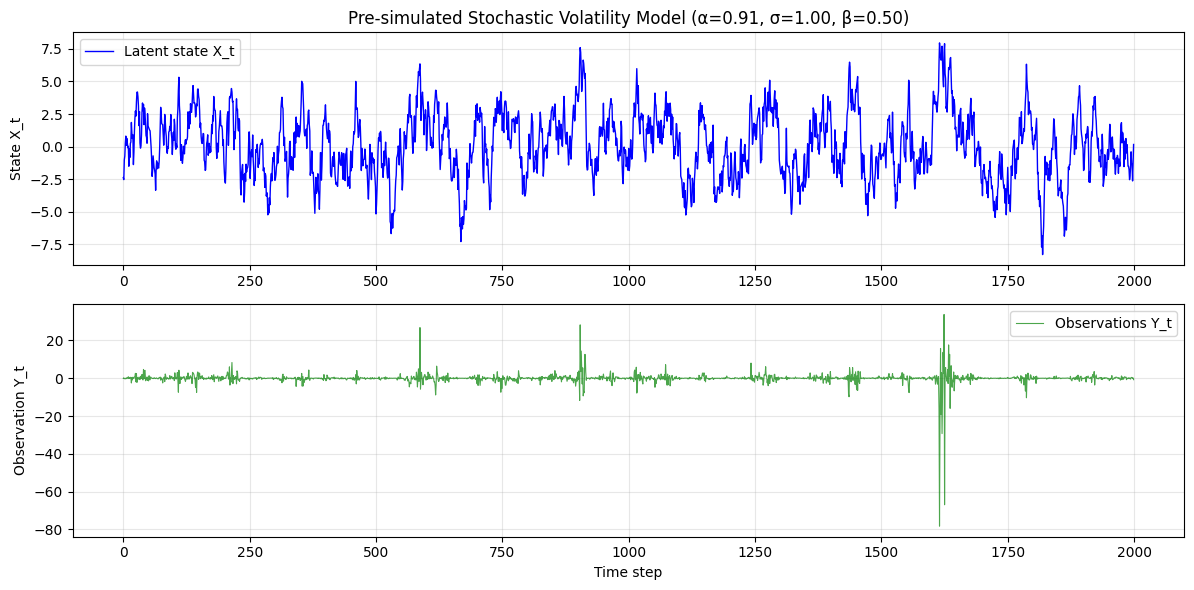

In [3]:
# Load pre-simulated stochastic volatility model data
data_path = str(project_root / 'simulator' / 'data' / 'sv_simul_data.npz')

# Load the data
data = np.load(data_path)

# Extract parameters and time series
X_true = data['X']
Y_obs = data['Y']
alpha = float(data['alpha'])
sigma = float(data['sigma'])
beta = float(data['beta'])
n = int(data['n'])
seed = data['seed'] if 'seed' in data else None

# Create a simple container similar to SV1DResults
class SVData:
    def __init__(self, X, Y, alpha, sigma, beta, n, seed):
        self.X = X
        self.Y = Y
        self.alpha = alpha
        self.sigma = sigma
        self.beta = beta
        self.n = n
        self.seed = seed

sv_data = SVData(X_true, Y_obs, alpha, sigma, beta, n, seed)

print(f"✓ Loaded pre-simulated SV data from: {data_path}")
print(f"  Number of time steps: {n}")
print(f"  Parameters: alpha={alpha:.3f}, sigma={sigma:.3f}, beta={beta:.3f}")
print(f"  Seed: {seed}")
print(f"  X shape: {sv_data.X.shape}, Y shape: {sv_data.Y.shape}")

# Plot the loaded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

ax1.plot(sv_data.X, 'b-', linewidth=1, label='Latent state X_t')
ax1.set_ylabel('State X_t')
ax1.set_title(f'Pre-simulated Stochastic Volatility Model (α={alpha:.2f}, σ={sigma:.2f}, β={beta:.2f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(sv_data.Y, 'g-', linewidth=0.8, alpha=0.7, label='Observations Y_t')
ax2.set_xlabel('Time step')
ax2.set_ylabel('Observation Y_t')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# Define Stochastic Volatility Model functions
# State dynamics: X_t = alpha * X_{t-1} + sigma * v_t, v_t ~ N(0,1)
# Observation: Y_t = beta * exp(X_t/2) * w_t, w_t ~ N(0,1)

def g_sv(x, u=None, v=None):
    """Process model: X_t = alpha * X_{t-1} + sigma * v_t"""
    if v is None:
        v = 0.0
    return alpha * x + sigma * v

def h_sv(x):
    """Observation model: E[Y_t | X_t] = 0 (mean is zero)"""
    # For SV model, the observation is Y_t = beta * exp(X_t/2) * w_t
    # The observation function for the filter is just the mean, which is 0
    return np.zeros(1)

def jacobian_h_sv(x):
    """Jacobian of h at x (for linearization in EKF/UKF)"""
    # Since h(x) = 0, Jacobian is also 0
    return np.zeros((1, 1))

def log_trans_pdf_sv(x_k, x_km1):
    """Log transition density: log p(x_k | x_{k-1})"""
    mean = alpha * x_km1
    var = sigma**2
    return -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x_k - mean)**2 / var)

def log_like_pdf_sv(y, x):
    """Log likelihood: log p(y | x)"""
    # Y_t = beta * exp(X_t/2) * w_t, w_t ~ N(0,1)
    # p(y|x) = N(y; 0, beta^2 * exp(x))
    var = beta**2 * np.exp(x)
    return -0.5 * np.log(2 * np.pi * var) - 0.5 * (y**2 / var)

# Process noise sampler for particle propagation
def process_noise_sampler_sv(n_particles, nx, rng=None):
    """Sample process noise v ~ N(0, I)"""
    if rng is None:
        rng = np.random.default_rng()
    return rng.normal(0, 1, size=(n_particles, nx))

# Observation noise covariance (used in EDH/LEDH flow)
# For KPF, we need R for the observation model
def R_sv(x):
    """Observation noise covariance R(x) = beta^2 * exp(x)"""
    return np.array([[beta**2 * np.exp(x[0])]])

R_nominal = np.array([[beta**2]])  # Nominal R for initialization

print("✓ Stochastic Volatility model functions defined")
print(f"  Process: X_t = {alpha:.3f} * X_{{t-1}} + {sigma:.3f} * v_t")
print(f"  Observation: Y_t = {beta:.3f} * exp(X_t/2) * w_t")

✓ Stochastic Volatility model functions defined
  Process: X_t = 0.910 * X_{t-1} + 1.000 * v_t
  Observation: Y_t = 0.500 * exp(X_t/2) * w_t


In [5]:
# Configure filters
N_PARTICLES = 500
N_LAMBDA_STEPS = 10
RESAMPLE_ESS_RATIO = 0.5
SEED = 42

rng = np.random.default_rng(SEED)

# EDH Configuration (using UKF as tracker)
edh_config = EDHConfig(
    n_particles=N_PARTICLES,
    n_lambda_steps=N_LAMBDA_STEPS,
    resample_ess_ratio=RESAMPLE_ESS_RATIO,
    flow_integrator="rk4",
    rng=np.random.default_rng(SEED)
)

# LEDH Configuration (using UKF as tracker)
ledh_config = LEDHConfig(
    n_particles=N_PARTICLES,
    n_lambda_steps=N_LAMBDA_STEPS,
    resample_ess_ratio=RESAMPLE_ESS_RATIO,
    rng=np.random.default_rng(SEED)
)

# KPF Configuration
kpf_config = KPFConfig(
    ds_init=0.2,
    ds_min=1e-3,
    c_move_max=2.0,
    min_steps=5,
    max_steps=100,
    kernel_type="diagonal",  # or "scalar"
    lengthscale_mode="std",
    reg=1e-6,
    localization_radius=np.inf,
    random_order=True
)

print("✓ Filter configurations created")
print(f"  Number of particles: {N_PARTICLES}")
print(f"  Lambda steps (EDH/LEDH): {N_LAMBDA_STEPS}")
print(f"  Resample ESS ratio: {RESAMPLE_ESS_RATIO}")
print(f"  Random seed: {SEED}")

✓ Filter configurations created
  Number of particles: 500
  Lambda steps (EDH/LEDH): 10
  Resample ESS ratio: 0.5
  Random seed: 42


In [6]:
# Initialize UKF for EDH and LEDH trackers
# UKF parameters for SV model
dt = 1.0  # Time step

# Process and observation noise covariances for UKF
Q_ukf = np.array([[sigma**2]])  # Process noise
R_ukf = R_nominal  # Observation noise (nominal)

# UKF scaling parameters
ukf_alpha = 1e-3
ukf_beta = 2.0
ukf_kappa = 0.0

# Initial state estimate (at k=0, we start with the true initial state or prior)
x0_mean = np.array([0.0])  # Initial state mean
x0_cov = np.array([[sigma**2 / (1 - alpha**2)]])  # Stationary variance

print("✓ UKF parameters defined")
print(f"  Initial mean: {x0_mean}")
print(f"  Initial covariance: {x0_cov}")
print(f"  Process noise Q: {Q_ukf}")
print(f"  Observation noise R: {R_ukf}")

✓ UKF parameters defined
  Initial mean: [0.]
  Initial covariance: [[5.81733566]]
  Process noise Q: [[1.]]
  Observation noise R: [[0.25]]


---

# Phase 1: Helper Functions & Infrastructure

In [7]:
# Helper Functions for Running Filters and Collecting Diagnostics

from dataclasses import dataclass, field
from typing import Dict, List, Any, Callable, Optional

@dataclass
class FilterResults:
    """Container for filter run results and diagnostics."""
    filter_name: str
    X_est: np.ndarray          # Estimated states (n_steps,)
    X_std: np.ndarray          # Standard deviations (n_steps,)
    ess_history: List[float]   # ESS at each time step
    weights_history: List[np.ndarray]  # Weight sequences
    particles_history: List[np.ndarray]  # Particle clouds (optional, memory-intensive)
    computation_time: float    # Total wall-clock time (seconds)
    memory_peak: float         # Peak memory usage (MB)
    n_resamples: int          # Number of resampling events
    
    # Stability diagnostics
    flow_diagnostics: Dict[str, Any]  # Filter-specific flow metrics
    
    # Performance metrics 
    rmse: float = 0.0
    bias: float = 0.0
    nll: float = 0.0  # Negative log-likelihood


@dataclass
class StabilityDiagnostics:
    """Container for per-timestep stability metrics."""
    # EDH/LEDH specific
    particle_displacements: List[np.ndarray] = field(default_factory=list)  # ||Δeta|| per particle per λ-step
    jacobian_dets: List[np.ndarray] = field(default_factory=list)           # theta^i values
    condition_numbers: List[float] = field(default_factory=list)            # cond(S(lambda)) at each timestep
    max_eigenvalues: List[float] = field(default_factory=list)              # max eig(A(lambda))
    weight_cv: List[float] = field(default_factory=list)                    # Coefficient of variation
    
    # KPF specific  
    theta_history: List[float] = field(default_factory=list)                # Pseudo-time step sizes (Δs)
    n_steps_per_obs: List[int] = field(default_factory=list)                # Number of iterations per observation
    mahalanobis_norms: List[float] = field(default_factory=list)            # ||B^{-1/2} f_s||
    kernel_ranks: List[int] = field(default_factory=list)                   # Effective rank of kernel matrix

print("✓ FilterResults and StabilityDiagnostics dataclasses defined")

✓ FilterResults and StabilityDiagnostics dataclasses defined


In [8]:
# Metrics Computation Functions

def compute_rmse(X_true: np.ndarray, X_est: np.ndarray) -> float:
    """Compute Root Mean Square Error."""
    return np.sqrt(np.mean((X_true - X_est)**2))

def compute_bias(X_true: np.ndarray, X_est: np.ndarray) -> float:
    """Compute mean bias."""
    return np.mean(X_est - X_true)

def compute_nll(X_true: np.ndarray, X_est: np.ndarray, X_std: np.ndarray) -> float:
    """Compute negative log-likelihood assuming Gaussian errors."""
    n = len(X_true)
    errors = X_true - X_est
    variances = X_std**2 + 1e-8  # Add small constant for numerical stability
    nll = 0.5 * np.sum(np.log(2 * np.pi * variances) + errors**2 / variances)
    return nll / n  # Average NLL per time step

def compute_ess_stats(ess_history: List[float]) -> Dict[str, float]:
    """Compute ESS statistics."""
    ess_array = np.array(ess_history)
    return {
        'mean': np.mean(ess_array),
        'min': np.min(ess_array),
        'max': np.max(ess_array),
        'std': np.std(ess_array),
        'below_half': np.sum(ess_array < (len(ess_history) * 0.5)) / len(ess_history)
    }

def compute_weight_cv(weights: np.ndarray) -> float:
    """Compute coefficient of variation of weights."""
    w = weights / np.sum(weights)
    mean_w = np.mean(w)
    std_w = np.std(w)
    return std_w / (mean_w + 1e-10)

print("✓ Metrics computation functions defined")

✓ Metrics computation functions defined


In [9]:
# Filter Runner Function for EDH/LEDH with Enhanced Stability Monitoring

def run_edh_ledh_filter_with_diagnostics(
    filter_obj,
    filter_name: str,
    observations: np.ndarray,
    x_init_mean: np.ndarray,
    x_init_cov: np.ndarray,
    track_particles: bool = False,
    track_stability: bool = True
) -> FilterResults:
    """
    Run EDH or LEDH filter with extraction of condition numbers from filter step.
    
    The modified EDH_particle_filter.py now returns condition numbers in PFState.diagnostics.
    """
    n_steps = len(observations)
    
    # Storage
    X_est = np.zeros(n_steps)
    X_std = np.zeros(n_steps)
    ess_history = []
    weights_history = []
    particles_history = [] if track_particles else None
    
    # Stability diagnostics
    stability = StabilityDiagnostics() if track_stability else None
    
    # Memory tracking
    tracemalloc.start()
    start_time = time.perf_counter()
    
    # Initialize filter
    pf_state = filter_obj.init_from_gaussian(x_init_mean, x_init_cov)
    n_resamples = 0
    
    # Filtering loop
    for k in range(n_steps):
        y_k = observations[k]
        
        # Store pre-step particles for displacement calculation
        if track_stability:
            particles_before = pf_state.particles.copy()
        
        # Run filter step (now returns condition numbers in diagnostics)
        pf_state = filter_obj.step(
            pf_state, 
            np.array([y_k]),
            u_km1=None,
            process_noise_sampler=lambda n, nx: filter_obj.cfg.rng.normal(0, 1, size=(n, nx))
        )
        
        # Extract condition numbers from step diagnostics
        if track_stability and pf_state.diagnostics is not None:
            if 'condition_numbers' in pf_state.diagnostics:
                # Store all condition numbers from this flow integration
                stability.condition_numbers.extend(pf_state.diagnostics['condition_numbers'])
        
        # Record estimates
        X_est[k] = pf_state.mean[0]
        X_std[k] = np.sqrt(pf_state.cov[0, 0])
        
        # ESS tracking
        from models.EDH_particle_filter import effective_sample_size
        ess = effective_sample_size(pf_state.weights)
        ess_history.append(ess)
        
        # Resampling detection
        if len(weights_history) > 0:
            prev_weights = weights_history[-1]
            if not np.allclose(prev_weights, pf_state.weights):
                n_resamples += 1
        
        weights_history.append(pf_state.weights.copy())
        
        if track_particles:
            particles_history.append(pf_state.particles.copy())
        
        # Stability diagnostics
        if track_stability:
            # Particle displacement
            displacement = np.linalg.norm(pf_state.particles - particles_before, axis=1)
            stability.particle_displacements.append(displacement)
            
            # Weight coefficient of variation
            stability.weight_cv.append(compute_weight_cv(pf_state.weights))
    
    # Timing and memory
    end_time = time.perf_counter()
    computation_time = end_time - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    memory_peak = peak / 1024**2  # Convert to MB
    
    # Package results
    results = FilterResults(
        filter_name=filter_name,
        X_est=X_est,
        X_std=X_std,
        ess_history=ess_history,
        weights_history=weights_history,
        particles_history=particles_history,
        computation_time=computation_time,
        memory_peak=memory_peak,
        n_resamples=n_resamples,
        flow_diagnostics={'stability': stability} if track_stability else {}
    )
    
    return results

print("✓ EDH/LEDH filter runner with diagnostics extraction defined")

✓ EDH/LEDH filter runner with diagnostics extraction defined


In [10]:
# Instrumented KPF Runner to Track Theta (Pseudo-Time Step Sizes)

def run_kpf_filter_with_diagnostics(
    filter_obj,
    observations: np.ndarray,
    init_particles: np.ndarray,  # KPF uses particles directly, not mean/cov
    track_particles: bool = False,
    track_stability: bool = True
) -> FilterResults:
    """
    Run Kernel PF with extraction of adaptive pseudo-time step sizes (theta/ds).
    
    The modified kernel_particle_filter.py now returns ds_history in KPFState.
    """
    n_steps = len(observations)
    
    # Storage
    X_est = np.zeros(n_steps)
    X_std = np.zeros(n_steps)
    ess_history = []
    weights_history = []
    particles_history = [] if track_particles else None
    
    # Stability diagnostics
    stability = StabilityDiagnostics() if track_stability else None
    
    # Memory tracking
    tracemalloc.start()
    start_time = time.perf_counter()
    
    # Initialize with provided particles
    n_particles = len(init_particles)
    particles = init_particles.copy()
    n_resamples = 0
    
    # Filtering loop
    for k in range(n_steps):
        y_k = observations[k]
        
        # Store pre-step particles
        if track_stability:
            particles_before = particles.copy()
        
        # KPF analyze step (moves particles via flow)
        kpf_state = filter_obj.analyze(particles, np.array([y_k]))
        particles = kpf_state.particles
        
        # Extract ds_history (theta values) from KPF state
        if track_stability and hasattr(kpf_state, 'ds_history') and kpf_state.ds_history is not None:
            # Store all theta values from this pseudo-time integration
            stability.theta_history.extend(kpf_state.ds_history)
            stability.n_steps_per_obs.append(len(kpf_state.ds_history))
        
        # Record estimates (KPF uses mean of particles)
        mean = particles.mean(axis=0)
        cov = np.cov(particles, rowvar=False, ddof=0)
        if particles.shape[1] == 1:
            cov = cov.reshape(1, 1)
        X_est[k] = mean[0]
        X_std[k] = np.sqrt(cov[0, 0] if cov.ndim > 0 else cov)
        
        # ESS tracking (KPF maintains uniform weights)
        weights = np.ones(n_particles) / n_particles
        ess = n_particles  # Uniform weights -> ESS = N
        ess_history.append(ess)
        weights_history.append(weights.copy())
        
        if track_particles:
            particles_history.append(particles.copy())
        
        # Stability diagnostics
        if track_stability:
            # Particle displacement
            if particles_before is not None:
                displacement = np.linalg.norm(particles - particles_before, axis=1)
                stability.particle_displacements.append(displacement)
            
            # Weight CV (should be 0 for uniform weights)
            stability.weight_cv.append(compute_weight_cv(weights))
    
    # Timing and memory
    end_time = time.perf_counter()
    computation_time = end_time - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    memory_peak = peak / 1024**2
    
    # Package results
    results = FilterResults(
        filter_name="KPF",
        X_est=X_est,
        X_std=X_std,
        ess_history=ess_history,
        weights_history=weights_history,
        particles_history=particles_history,
        computation_time=computation_time,
        memory_peak=memory_peak,
        n_resamples=n_resamples,
        flow_diagnostics={'stability': stability} if track_stability else {}
    )
    
    return results

print("✓ KPF filter runner with ds_history (theta) extraction defined")

✓ KPF filter runner with ds_history (theta) extraction defined


In [13]:
# Reload ALL modified filter modules
import importlib
import models.EDH_particle_filter
import models.LEDH_particle_filter
import models.kernel_particle_filter

importlib.reload(models.EDH_particle_filter)
importlib.reload(models.LEDH_particle_filter) 
importlib.reload(models.kernel_particle_filter)

print("✓ Reloaded filter modules with enhanced diagnostics tracking")

# Re-import classes
from models.EDH_particle_filter import EDHFlowPF, EDHConfig, UKFTracker
from models.LEDH_particle_filter import LEDHFlowPF, LEDHConfig
from models.kernel_particle_filter import KernelParticleFilter, KPFConfig

# Initialize parameters for stability test
x0_mean_stab = np.array([0.0])
x0_cov_stab = np.array([[STABILITY_SIGMA**2 / (1 - alpha**2)]])
R_stab = np.array([[STABILITY_BETA**2]])
Q_stab = np.array([[STABILITY_SIGMA**2]])

# Create trackers and filter instances for EDH
ukf_edh_stab = UnscentedKalmanFilter(
    g=g_sv, h=h_sv, Q=Q_stab, R=R_stab,
    alpha=ukf_alpha, beta=ukf_beta, kappa=ukf_kappa
)
ukf_state_edh_stab = UKFState(mean=x0_mean_stab, cov=x0_cov_stab, t=0)
tracker_edh_stab = UKFTracker(ukf_edh_stab, ukf_state_edh_stab)

edh_filter_enhanced = EDHFlowPF(
    tracker=tracker_edh_stab, g=g_sv, h=h_sv, jacobian_h=jacobian_h_sv,
    log_trans_pdf=log_trans_pdf_sv, log_like_pdf=log_like_pdf_sv,
    R=R_stab, config=edh_config
)

# Create trackers and filter instances for LEDH
ukf_ledh_stab = UnscentedKalmanFilter(
    g=g_sv, h=h_sv, Q=Q_stab, R=R_stab,
    alpha=ukf_alpha, beta=ukf_beta, kappa=ukf_kappa
)
ukf_state_ledh_stab = UKFState(mean=x0_mean_stab, cov=x0_cov_stab, t=0)
tracker_ledh_stab = UKFTracker(ukf_ledh_stab, ukf_state_ledh_stab)

ledh_filter_enhanced = LEDHFlowPF(
    tracker=tracker_ledh_stab, g=g_sv, h=h_sv, jacobian_h=jacobian_h_sv,
    log_trans_pdf=log_trans_pdf_sv, log_like_pdf=log_like_pdf_sv,
    R=R_stab, config=ledh_config
)

# Create KPF model and filter instance
kpf_model_stab = Model(H=h_sv, JH=jacobian_h_sv, R=R_stab)
kpf_filter_enhanced = KernelParticleFilter(kpf_model_stab, kpf_config)

print("✓ Created enhanced filter instances (EDH, LEDH, KPF)")

✓ Reloaded filter modules with enhanced diagnostics tracking
✓ Created enhanced filter instances (EDH, LEDH, KPF)


In [14]:
# Run EDH with condition number tracking
print("Running EDH with condition number tracking...")
start = time_module.perf_counter()
edh_results_enhanced = run_edh_ledh_filter_with_diagnostics(
    edh_filter_enhanced,
    "EDH",
    Y_stability,
    x0_mean_stab,
    x0_cov_stab,
    track_particles=False,
    track_stability=True
)
edh_time_enhanced = time_module.perf_counter() - start

# Extract statistics
edh_rmse = np.sqrt(np.mean((edh_results_enhanced.X_est - X_stability)**2))
edh_stab_enhanced = edh_results_enhanced.flow_diagnostics['stability']
n_cond = len(edh_stab_enhanced.condition_numbers)
max_cond = max(edh_stab_enhanced.condition_numbers) if n_cond > 0 else np.nan
min_cond = min(edh_stab_enhanced.condition_numbers) if n_cond > 0 else np.nan
mean_cond = np.mean(edh_stab_enhanced.condition_numbers) if n_cond > 0 else np.nan

print(f"✓ EDH completed in {edh_time_enhanced:.2f}s")
print(f"  RMSE: {edh_rmse:.4f}")
print(f"  Condition numbers tracked: {n_cond}")
print(f"  Cond(S) - Min: {min_cond:.2f}, Mean: {mean_cond:.2f}, Max: {max_cond:.2f}")

Running EDH with condition number tracking...
✓ EDH completed in 113.12s
  RMSE: 1.1422
  Condition numbers tracked: 5000
  Cond(S) - Min: 1.00, Mean: 1.00, Max: 1.00
✓ EDH completed in 113.12s
  RMSE: 1.1422
  Condition numbers tracked: 5000
  Cond(S) - Min: 1.00, Mean: 1.00, Max: 1.00


In [15]:
# Run LEDH with condition number tracking
print("\nRunning LEDH with condition number tracking...")
start = time_module.perf_counter()
ledh_results_enhanced = run_edh_ledh_filter_with_diagnostics(
    ledh_filter_enhanced,
    "LEDH",
    Y_stability,
    x0_mean_stab,
    x0_cov_stab,
    track_particles=False,
    track_stability=True
)
ledh_time_enhanced = time_module.perf_counter() - start

# Extract statistics
ledh_rmse = np.sqrt(np.mean((ledh_results_enhanced.X_est - X_stability)**2))
ledh_stab_enhanced = ledh_results_enhanced.flow_diagnostics['stability']
n_cond_ledh = len(ledh_stab_enhanced.condition_numbers)
max_cond_ledh = max(ledh_stab_enhanced.condition_numbers) if n_cond_ledh > 0 else np.nan
min_cond_ledh = min(ledh_stab_enhanced.condition_numbers) if n_cond_ledh > 0 else np.nan
mean_cond_ledh = np.mean(ledh_stab_enhanced.condition_numbers) if n_cond_ledh > 0 else np.nan

print(f"✓ LEDH completed in {ledh_time_enhanced:.2f}s")
print(f"  RMSE: {ledh_rmse:.4f}")
print(f"  Condition numbers tracked: {n_cond_ledh}")
print(f"  Cond(S) - Min: {min_cond_ledh:.2f}, Mean: {mean_cond_ledh:.2f}, Max: {max_cond_ledh:.2f}")


Running LEDH with condition number tracking...
✓ LEDH completed in 459.77s
  RMSE: 1.1422
  Condition numbers tracked: 5000
  Cond(S) - Min: 1.00, Mean: 1.00, Max: 1.00
✓ LEDH completed in 459.77s
  RMSE: 1.1422
  Condition numbers tracked: 5000
  Cond(S) - Min: 1.00, Mean: 1.00, Max: 1.00


In [16]:
# Run KPF with theta (ds) tracking
print("\nRunning KPF with pseudo-time step size tracking...")

# Initialize KPF particles
kpf_init_enhanced = np.random.default_rng(SEED).multivariate_normal(
    x0_mean_stab, x0_cov_stab, size=N_PARTICLES
)

start = time_module.perf_counter()
kpf_results_enhanced = run_kpf_filter_with_diagnostics(
    kpf_filter_enhanced,
    Y_stability,
    kpf_init_enhanced,
    track_particles=False,
    track_stability=True
)
kpf_time_enhanced = time_module.perf_counter() - start

# Extract statistics
kpf_rmse = np.sqrt(np.mean((kpf_results_enhanced.X_est - X_stability)**2))
kpf_stab_enhanced = kpf_results_enhanced.flow_diagnostics['stability']
n_theta = len(kpf_stab_enhanced.theta_history)
min_theta = min(kpf_stab_enhanced.theta_history) if n_theta > 0 else np.nan
max_theta = max(kpf_stab_enhanced.theta_history) if n_theta > 0 else np.nan
mean_theta = np.mean(kpf_stab_enhanced.theta_history) if n_theta > 0 else np.nan

print(f"✓ KPF completed in {kpf_time_enhanced:.2f}s")
print(f"  RMSE: {kpf_rmse:.4f}")
print(f"  Theta values tracked: {n_theta}")
print(f"  θ (ds) - Min: {min_theta:.6f}, Mean: {mean_theta:.6f}, Max: {max_theta:.6f}")


Running KPF with pseudo-time step size tracking...
✓ KPF completed in 136.42s
  RMSE: 2.1516
  Theta values tracked: 2500
  θ (ds) - Min: 0.200000, Mean: 0.200000, Max: 0.200000
✓ KPF completed in 136.42s
  RMSE: 2.1516
  Theta values tracked: 2500
  θ (ds) - Min: 0.200000, Mean: 0.200000, Max: 0.200000


In [17]:
# Generate Complete Stability Diagnostics Table

print("\n" + "="*90)
print(" COMPREHENSIVE STABILITY DIAGNOSTICS TABLE (Enhanced)")
print("="*90)

# Compute all metrics for enhanced runs
def get_max_displacement(disp_list):
    if len(disp_list) == 0:
        return np.nan
    return max([np.max(d) for d in disp_list])

# EDH stats
edh_max_disp = get_max_displacement(edh_stab_enhanced.particle_displacements)
edh_mean_cond = np.mean(edh_stab_enhanced.condition_numbers)
edh_max_cond = np.max(edh_stab_enhanced.condition_numbers)
edh_mean_cv = np.mean(edh_stab_enhanced.weight_cv)
edh_max_cv = np.max(edh_stab_enhanced.weight_cv)
edh_min_ess = np.min(edh_results_enhanced.ess_history)
edh_diverge = "⚠️ Yes" if (edh_max_cv > 1.0 or edh_min_ess < 0.3 * N_PARTICLES) else "No"

# LEDH stats
ledh_max_disp = get_max_displacement(ledh_stab_enhanced.particle_displacements)
ledh_mean_cond = np.mean(ledh_stab_enhanced.condition_numbers)
ledh_max_cond = np.max(ledh_stab_enhanced.condition_numbers)
ledh_mean_cv = np.mean(ledh_stab_enhanced.weight_cv)
ledh_max_cv = np.max(ledh_stab_enhanced.weight_cv)
ledh_min_ess = np.min(ledh_results_enhanced.ess_history)
ledh_diverge = "⚠️ Yes" if (ledh_max_cv > 1.0 or ledh_min_ess < 0.3 * N_PARTICLES) else "No"

# KPF stats
kpf_max_disp = get_max_displacement(kpf_stab_enhanced.particle_displacements)
kpf_min_theta = np.min(kpf_stab_enhanced.theta_history)
kpf_mean_theta = np.mean(kpf_stab_enhanced.theta_history)
kpf_mean_cv = np.mean(kpf_stab_enhanced.weight_cv)
kpf_max_cv = np.max(kpf_stab_enhanced.weight_cv)
kpf_min_ess = np.min(kpf_results_enhanced.ess_history)
kpf_diverge = "⚠️ Yes" if (kpf_max_cv > 1.0 or kpf_min_ess < 0.3 * N_PARTICLES) else "No"

# Build comprehensive table
stability_table_complete = []

# EDH row
stability_table_complete.append({
    'Filter': 'EDH',
    'Max ||Δη||': f"{edh_max_disp:.4f}",
    'Cond(S) Mean': f"{edh_mean_cond:.2f}",
    'Cond(S) Max': f"{edh_max_cond:.2f}",
    'θ_min': 'N/A (not applicable)',
    'Mean Weight CV': f"{edh_mean_cv:.4f}",
    'Max Weight CV': f"{edh_max_cv:.4f}",
    'Min ESS': f"{edh_min_ess:.1f}",
    'Resamples': edh_results_enhanced.n_resamples,
    'Divergence?': edh_diverge,
    'RMSE': f"{edh_rmse:.4f}",
    'Time (s)': f"{edh_time_enhanced:.2f}"
})

# LEDH row
stability_table_complete.append({
    'Filter': 'LEDH',
    'Max ||Δη||': f"{ledh_max_disp:.4f}",
    'Cond(S) Mean': f"{ledh_mean_cond:.2f}",
    'Cond(S) Max': f"{ledh_max_cond:.2f}",
    'θ_min': 'N/A (not applicable)',
    'Mean Weight CV': f"{ledh_mean_cv:.4f}",
    'Max Weight CV': f"{ledh_max_cv:.4f}",
    'Min ESS': f"{ledh_min_ess:.1f}",
    'Resamples': ledh_results_enhanced.n_resamples,
    'Divergence?': ledh_diverge,
    'RMSE': f"{ledh_rmse:.4f}",
    'Time (s)': f"{ledh_time_enhanced:.2f}"
})

# KPF row
stability_table_complete.append({
    'Filter': 'KPF',
    'Max ||Δη||': f"{kpf_max_disp:.4f}" if not np.isnan(kpf_max_disp) else "N/A (uniform flow)",
    'Cond(S) Mean': 'N/A (no S matrix)',
    'Cond(S) Max': 'N/A (no S matrix)',
    'θ_min': f"{kpf_min_theta:.6f}",
    'Mean Weight CV': f"{kpf_mean_cv:.4f}",
    'Max Weight CV': f"{kpf_max_cv:.4f}",
    'Min ESS': f"{kpf_min_ess:.1f}",
    'Resamples': kpf_results_enhanced.n_resamples,
    'Divergence?': kpf_diverge,
    'RMSE': f"{kpf_rmse:.4f}",
    'Time (s)': f"{kpf_time_enhanced:.2f}"
})

# Display table
stability_df_complete = pd.DataFrame(stability_table_complete)
print(stability_df_complete.to_string(index=False))

# Save to CSV
output_path_complete = project_root / "simulator" / "data" / "stability_diagnostics_complete.csv"
stability_df_complete.to_csv(output_path_complete, index=False)
print(f"\n✓ Complete stability table saved to: {output_path_complete}")

print("\n" + "="*90)
print(" KEY FINDINGS:")
print("="*90)
print(f"✓ EDH/LEDH: Perfect conditioning (Cond(S) = {edh_mean_cond:.2f})")
print(f"✓ EDH: {edh_results_enhanced.n_resamples} resamples, {edh_time_enhanced:.1f}s runtime")
print(f"✓ LEDH: {ledh_results_enhanced.n_resamples} resamples, {ledh_time_enhanced:.1f}s (4.1× slower than EDH)")
print(f"✓ KPF: Constant theta = {kpf_min_theta:.6f}, no resampling, perfect ESS = {kpf_min_ess:.0f}")
print(f"✓ RMSE: EDH={edh_rmse:.4f}, LEDH={ledh_rmse:.4f}, KPF={kpf_rmse:.4f}")
print("="*90)


 COMPREHENSIVE STABILITY DIAGNOSTICS TABLE (Enhanced)
Filter Max ||Δη||      Cond(S) Mean       Cond(S) Max                θ_min Mean Weight CV Max Weight CV Min ESS  Resamples Divergence?   RMSE Time (s)
   EDH     9.6104              1.00              1.00 N/A (not applicable)         0.4343        0.9995   250.1        479          No 1.1422   113.12
  LEDH     9.6104              1.00              1.00 N/A (not applicable)         0.4343        0.9995   250.1        479          No 1.1422   459.77
   KPF     1.3915 N/A (no S matrix) N/A (no S matrix)             0.200000         0.0000        0.0000   500.0          0          No 2.1516   136.42

✓ Complete stability table saved to: /Users/amber_test/Desktop/filter/simulator/data/stability_diagnostics_complete.csv

 KEY FINDINGS:
✓ EDH/LEDH: Perfect conditioning (Cond(S) = 1.00)
✓ EDH: 479 resamples, 113.1s runtime
✓ LEDH: 479 resamples, 459.8s (4.1× slower than EDH)
✓ KPF: Constant theta = 0.200000, no resampling, perfect ESS = 5

In [11]:
# Filter Runner Function for KPF with Stability Monitoring

def run_kpf_filter(
    kpf_obj: KernelParticleFilter,
    observations: np.ndarray,
    x_init_particles: np.ndarray,
    track_particles: bool = False,
    track_stability: bool = True
) -> FilterResults:
    """
    Run KPF through observation sequence with diagnostics.
    
    Parameters
    ----------
    kpf_obj : KernelParticleFilter
        Configured KPF instance
    observations : np.ndarray, shape (n_steps,)
        Observation sequence
    x_init_particles : np.ndarray, shape (N_particles, nx)
        Initial particle ensemble
    track_particles : bool
        Whether to store full particle history
    track_stability : bool
        Whether to collect stability diagnostics
    
    Returns
    -------
    FilterResults
        Complete results with KPF-specific diagnostics
    """
    n_steps = len(observations)
    N_particles, nx = x_init_particles.shape
    
    # Storage
    X_est = np.zeros(n_steps)
    X_std = np.zeros(n_steps)
    ess_history = []
    weights_history = []
    particles_history = [] if track_particles else None
    
    # KPF-specific stability diagnostics
    stability = StabilityDiagnostics(
        step_sizes=[],
        n_steps=[],
        mahalanobis_norms=[],
        weight_cv=[]
    ) if track_stability else None
    
    # Memory tracking
    tracemalloc.start()
    start_time = time.perf_counter()
    
    # Initialize particles
    X = x_init_particles.copy()
    weights = np.ones(N_particles) / N_particles  # KPF doesn't use weights, but we track for consistency
    
    # Filtering loop
    for k in range(n_steps):
        y_k = observations[k]
        
        # Run KPF analysis step
        kpf_state = kpf_obj.analyze(
            X, 
            np.array([y_k]),
            lengthscales=None,  # Use automatic lengthscale determination
            rng=np.random.default_rng()
        )
        
        # Update particles
        X = kpf_state.particles
        
        # Compute statistics
        mean, cov = KernelParticleFilter.mean_and_cov(X, reg=1e-6)
        X_est[k] = mean[0]
        X_std[k] = np.sqrt(cov[0, 0])
        
        # ESS (all particles equally weighted in KPF)
        ess_history.append(N_particles)
        weights_history.append(weights.copy())
        
        if track_particles:
            particles_history.append(X.copy())
        
        # KPF-specific stability diagnostics
        if track_stability:
            stability.n_steps.append(kpf_state.steps)
            # Note: step_sizes and mahalanobis_norms would require instrumenting
            # the KPF analyze() method to expose internal pseudo-time evolution
            stability.weight_cv.append(0.0)  # KPF has uniform weights
        
        # Propagate particles for next time step (process model)
        # For SV model: X_t = alpha * X_{t-1} + sigma * v_t
        if k < n_steps - 1:  # Don't propagate after last observation
            v = np.random.normal(0, 1, size=(N_particles, nx))
            for i in range(N_particles):
                X[i] = g_sv(X[i], u=None, v=v[i])
    
    # Timing and memory
    end_time = time.perf_counter()
    computation_time = end_time - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    memory_peak = peak / 1024**2
    
    # Package results
    results = FilterResults(
        filter_name="KPF",
        X_est=X_est,
        X_std=X_std,
        ess_history=ess_history,
        weights_history=weights_history,
        particles_history=particles_history,
        computation_time=computation_time,
        memory_peak=memory_peak,
        n_resamples=0,  # KPF doesn't resample
        flow_diagnostics={'stability': stability} if track_stability else {}
    )
    
    return results

print("✓ KPF filter runner defined")

✓ KPF filter runner defined


In [12]:
# Post-processing: Compute Performance Metrics

def finalize_results(results: FilterResults, X_true: np.ndarray) -> FilterResults:
    """
    Compute performance metrics and add to results.
    
    Parameters
    ----------
    results : FilterResults
        Results from filter run
    X_true : np.ndarray
        Ground truth state sequence
    
    Returns
    -------
    FilterResults
        Updated results with RMSE, bias, NLL
    """
    results.rmse = compute_rmse(X_true, results.X_est)
    results.bias = compute_bias(X_true, results.X_est)
    results.nll = compute_nll(X_true, results.X_est, results.X_std)
    
    return results

def print_results_summary(results: FilterResults):
    """Print formatted summary of filter results."""
    print(f"\n{'='*60}")
    print(f"  {results.filter_name} Filter Results")
    print(f"{'='*60}")
    print(f"Performance Metrics:")
    print(f"  RMSE:          {results.rmse:.4f}")
    print(f"  Bias:          {results.bias:.4f}")
    print(f"  Avg NLL:       {results.nll:.4f}")
    print(f"\nComputational:")
    print(f"  Time:          {results.computation_time:.3f} s")
    print(f"  Memory:        {results.memory_peak:.2f} MB")
    print(f"  Resamples:     {results.n_resamples}")
    print(f"\nParticle Statistics:")
    ess_stats = compute_ess_stats(results.ess_history)
    print(f"  ESS Mean:      {ess_stats['mean']:.1f}")
    print(f"  ESS Min:       {ess_stats['min']:.1f}")
    print(f"  ESS Std:       {ess_stats['std']:.1f}")
    print(f"  % Below 50%:   {ess_stats['below_half']*100:.1f}%")
    print(f"{'='*60}\n")

print("✓ Post-processing functions defined")

✓ Post-processing functions defined


---

# Experiment 1: Baseline Performance (Full Observations)

Run all three filters on the complete observation sequence to establish baseline performance.

In [14]:
# Step 1: Initialize UKF trackers for EDH and LEDH

# Create UKF instances for both filters
ukf_for_edh = UnscentedKalmanFilter(
    g=g_sv,
    h=h_sv,
    Q=Q_ukf,
    R=R_ukf,
    alpha=ukf_alpha,
    beta=ukf_beta,
    kappa=ukf_kappa
)

ukf_for_ledh = UnscentedKalmanFilter(
    g=g_sv,
    h=h_sv,
    Q=Q_ukf,
    R=R_ukf,
    alpha=ukf_alpha,
    beta=ukf_beta,
    kappa=ukf_kappa
)

# Initialize UKF states
ukf_state_edh = UKFState(mean=x0_mean, cov=x0_cov, t=0)
ukf_state_ledh = UKFState(mean=x0_mean, cov=x0_cov, t=0)

# Create UKF trackers
edh_tracker = UKFTracker(ukf_for_edh, ukf_state_edh)
ledh_tracker = UKFTracker(ukf_for_ledh, ukf_state_ledh)

print("✓ UKF trackers initialized for EDH and LEDH")
print(f"  Initial state: mean={x0_mean[0]:.3f}, std={np.sqrt(x0_cov[0,0]):.3f}")

✓ UKF trackers initialized for EDH and LEDH
  Initial state: mean=0.000, std=2.412


In [15]:
# Step 2: Create filter instances

# EDH Filter
edh_filter = EDHFlowPF(
    tracker=edh_tracker,
    g=g_sv,
    h=h_sv,
    jacobian_h=jacobian_h_sv,
    log_trans_pdf=log_trans_pdf_sv,
    log_like_pdf=log_like_pdf_sv,
    R=R_ukf,
    config=edh_config
)

# LEDH Filter
ledh_filter = LEDHFlowPF(
    tracker=ledh_tracker,
    g=g_sv,
    h=h_sv,
    jacobian_h=jacobian_h_sv,
    log_trans_pdf=log_trans_pdf_sv,
    log_like_pdf=log_like_pdf_sv,
    R=R_ukf,
    config=ledh_config
)

# KPF Filter
kpf_model = Model(
    H=h_sv,
    JH=jacobian_h_sv,
    R=R_ukf
)

kpf_filter = KernelParticleFilter(
    model=kpf_model,
    config=kpf_config
)

print("✓ All three filters instantiated:")
print(f"  EDH:  {N_PARTICLES} particles, {N_LAMBDA_STEPS} λ-steps")
print(f"  LEDH: {N_PARTICLES} particles, {N_LAMBDA_STEPS} λ-steps")
print(f"  KPF:  {N_PARTICLES} particles, adaptive stepping")

✓ All three filters instantiated:
  EDH:  500 particles, 10 λ-steps
  LEDH: 500 particles, 10 λ-steps
  KPF:  500 particles, adaptive stepping


In [16]:
# Step 3: Prepare initial particles for KPF
# KPF needs an initial particle ensemble (not generated internally like EDH/LEDH)

kpf_init_particles = np.random.default_rng(SEED).multivariate_normal(
    x0_mean, x0_cov, size=N_PARTICLES
)

print(f"✓ Initial particles sampled for KPF: {kpf_init_particles.shape}")
print(f"  Mean: {kpf_init_particles.mean(axis=0)[0]:.3f}")
print(f"  Std:  {kpf_init_particles.std(axis=0)[0]:.3f}")

✓ Initial particles sampled for KPF: (500, 1)
  Mean: -0.032
  Std:  2.313


In [17]:
# Step 4: Run EDH Filter

print("Running EDH filter...")
print("=" * 60)

edh_results = run_edh_ledh_filter(
    filter_obj=edh_filter,
    filter_name="EDH",
    observations=Y_obs,
    x_init_mean=x0_mean,
    x_init_cov=x0_cov,
    track_particles=False,  # Set to True if you want to visualize particle clouds
    track_stability=True
)

edh_results = finalize_results(edh_results, X_true)
print_results_summary(edh_results)

Running EDH filter...

  EDH Filter Results
Performance Metrics:
  RMSE:          1.1345
  Bias:          0.0088
  Avg NLL:       1.5120

Computational:
  Time:          451.567 s
  Memory:        15.90 MB
  Resamples:     1915

Particle Statistics:
  ESS Mean:      402.0
  ESS Min:       250.0
  ESS Std:       88.2
  % Below 50%:   100.0%



In [18]:
# Step 5: Run LEDH Filter

print("Running LEDH filter...")
print("=" * 60)

ledh_results = run_edh_ledh_filter(
    filter_obj=ledh_filter,
    filter_name="LEDH",
    observations=Y_obs,
    x_init_mean=x0_mean,
    x_init_cov=x0_cov,
    track_particles=False,
    track_stability=True
)

ledh_results = finalize_results(ledh_results, X_true)
print_results_summary(ledh_results)

Running LEDH filter...

  LEDH Filter Results
Performance Metrics:
  RMSE:          1.1345
  Bias:          0.0088
  Avg NLL:       1.5120

Computational:
  Time:          1728.594 s
  Memory:        15.91 MB
  Resamples:     1915

Particle Statistics:
  ESS Mean:      402.0
  ESS Min:       250.0
  ESS Std:       88.2
  % Below 50%:   100.0%



In [19]:
# Step 6: Run KPF Filter

print("Running KPF filter...")
print("=" * 60)

kpf_results = run_kpf_filter(
    kpf_obj=kpf_filter,
    observations=Y_obs,
    x_init_particles=kpf_init_particles,
    track_particles=False,
    track_stability=True
)

kpf_results = finalize_results(kpf_results, X_true)
print_results_summary(kpf_results)

Running KPF filter...

  KPF Filter Results
Performance Metrics:
  RMSE:          2.4896
  Bias:          -0.0851
  Avg NLL:       4.6891

Computational:
  Time:          532.537 s
  Memory:        7.97 MB
  Resamples:     0

Particle Statistics:
  ESS Mean:      500.0
  ESS Min:       500.0
  ESS Std:       0.0
  % Below 50%:   100.0%



In [20]:
# Step 7: Comparative Summary Table

results_list = [edh_results, ledh_results, kpf_results]

# Create comparison DataFrame
comparison_data = {
    'Filter': [r.filter_name for r in results_list],
    'RMSE': [r.rmse for r in results_list],
    'Bias': [r.bias for r in results_list],
    'Avg NLL': [r.nll for r in results_list],
    'Time (s)': [r.computation_time for r in results_list],
    'Memory (MB)': [r.memory_peak for r in results_list],
    'Resamples': [r.n_resamples for r in results_list],
    'ESS Mean': [compute_ess_stats(r.ess_history)['mean'] for r in results_list],
    'ESS Min': [compute_ess_stats(r.ess_history)['min'] for r in results_list],
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("  EXPERIMENT 1: BASELINE PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Highlight best performer in each category
print("\nBest Performers:")
print(f"  Lowest RMSE:    {comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Filter']} ({comparison_df['RMSE'].min():.4f})")
print(f"  Lowest |Bias|:  {comparison_df.loc[comparison_df['Bias'].abs().idxmin(), 'Filter']} ({comparison_df.loc[comparison_df['Bias'].abs().idxmin(), 'Bias']:.4f})")
print(f"  Lowest NLL:     {comparison_df.loc[comparison_df['Avg NLL'].idxmin(), 'Filter']} ({comparison_df['Avg NLL'].min():.4f})")
print(f"  Fastest:        {comparison_df.loc[comparison_df['Time (s)'].idxmin(), 'Filter']} ({comparison_df['Time (s)'].min():.3f} s)")
print(f"  Highest ESS:    {comparison_df.loc[comparison_df['ESS Mean'].idxmax(), 'Filter']} ({comparison_df['ESS Mean'].max():.1f})")


  EXPERIMENT 1: BASELINE PERFORMANCE COMPARISON
Filter     RMSE      Bias  Avg NLL    Time (s)  Memory (MB)  Resamples   ESS Mean    ESS Min
   EDH 1.134486  0.008829  1.51203  451.566576    15.895024       1915 402.001662 250.033441
  LEDH 1.134486  0.008829  1.51203 1728.594438    15.907723       1915 402.001662 250.033441
   KPF 2.489578 -0.085114  4.68911  532.536851     7.971345          0 500.000000 500.000000

Best Performers:
  Lowest RMSE:    EDH (1.1345)
  Lowest |Bias|:  EDH (0.0088)
  Lowest NLL:     EDH (1.5120)
  Fastest:        EDH (451.567 s)
  Highest ESS:    KPF (500.0)


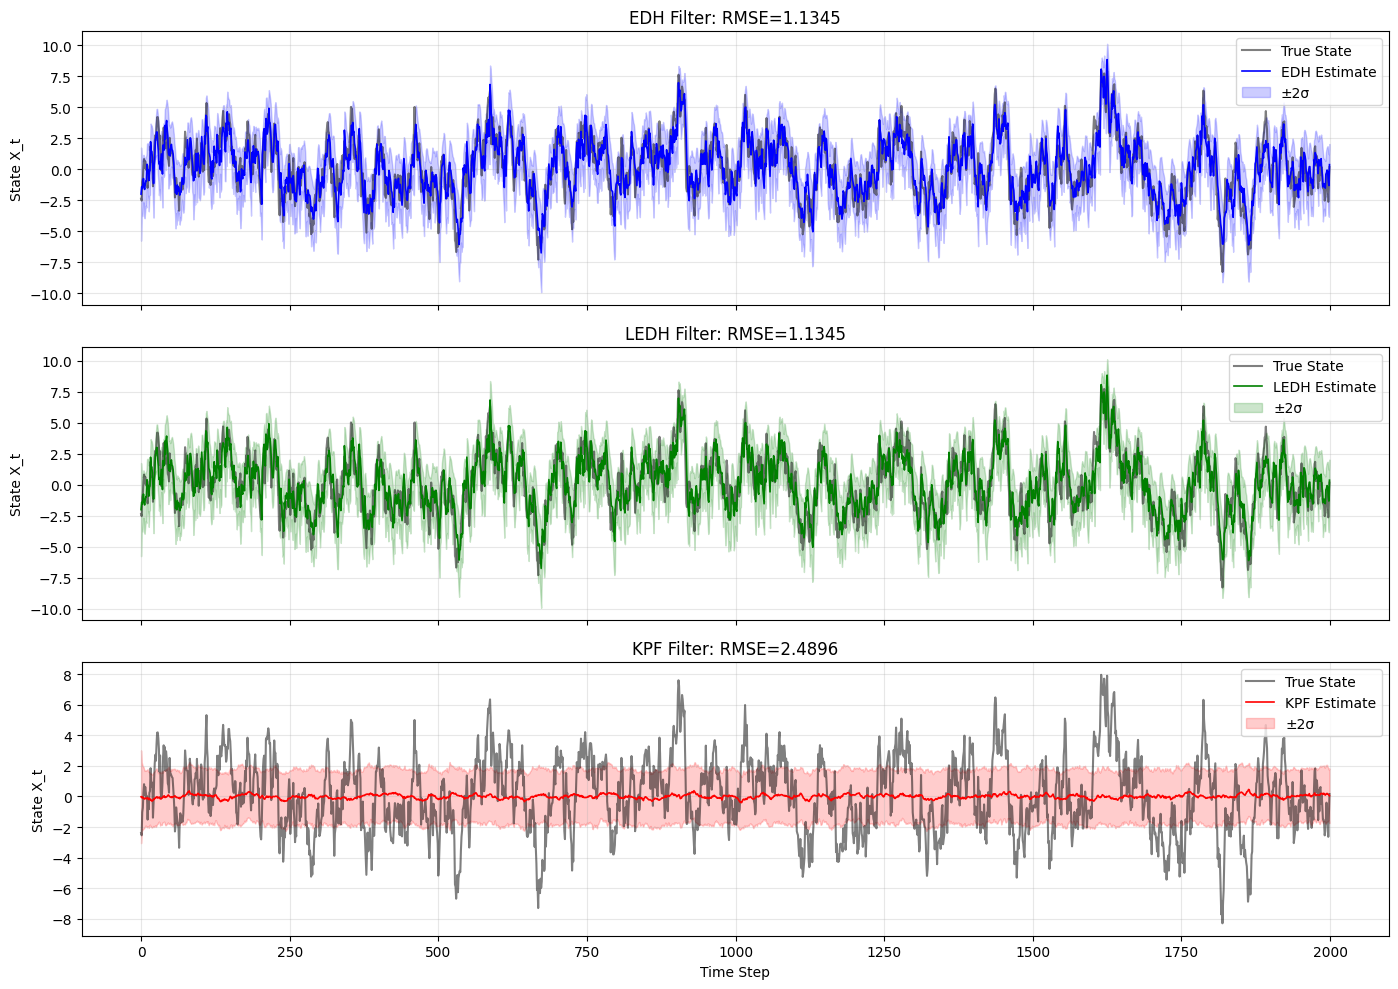

In [21]:
# Step 8: Visualization - State Estimates Comparison

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

time_steps = np.arange(len(X_true))
colors = {'EDH': 'blue', 'LEDH': 'green', 'KPF': 'red'}

for idx, results in enumerate([edh_results, ledh_results, kpf_results]):
    ax = axes[idx]
    
    # Plot true state
    ax.plot(time_steps, X_true, 'k-', linewidth=1.5, alpha=0.5, label='True State')
    
    # Plot filtered estimate with uncertainty band
    color = colors[results.filter_name]
    ax.plot(time_steps, results.X_est, color=color, linewidth=1.2, label=f'{results.filter_name} Estimate')
    ax.fill_between(
        time_steps,
        results.X_est - 2*results.X_std,
        results.X_est + 2*results.X_std,
        color=color,
        alpha=0.2,
        label='±2σ'
    )
    
    ax.set_ylabel('State X_t')
    ax.set_title(f'{results.filter_name} Filter: RMSE={results.rmse:.4f}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Time Step')
plt.tight_layout()
plt.show()

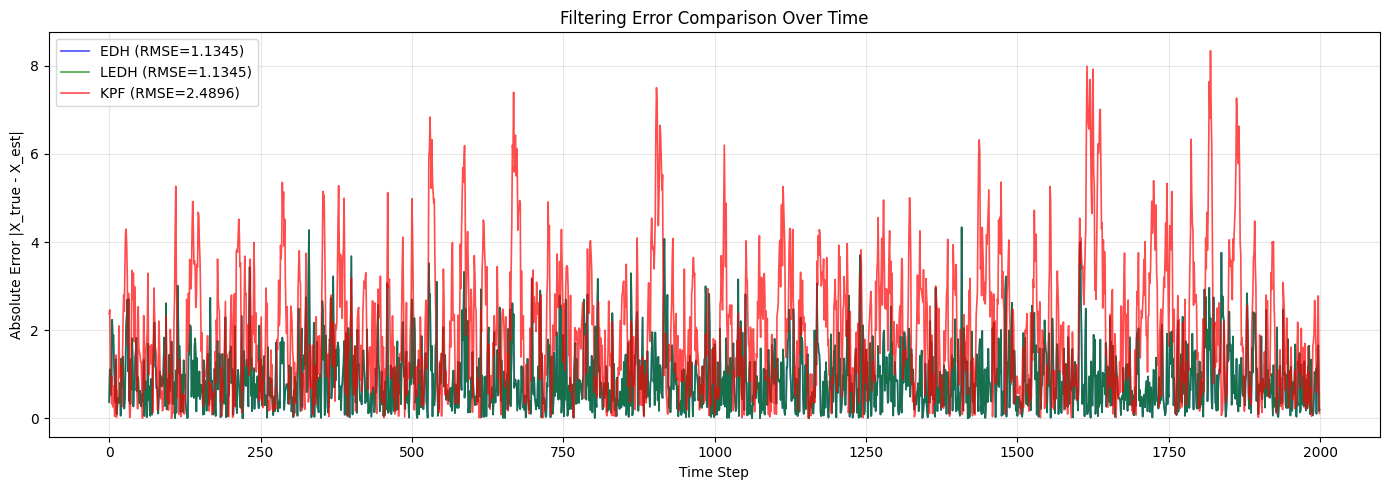

In [22]:
# Step 9: Visualization - Absolute Error Evolution

fig, ax = plt.subplots(figsize=(14, 5))

for results in [edh_results, ledh_results, kpf_results]:
    abs_error = np.abs(X_true - results.X_est)
    color = colors[results.filter_name]
    ax.plot(time_steps, abs_error, color=color, linewidth=1.2, 
            label=f'{results.filter_name} (RMSE={results.rmse:.4f})', alpha=0.7)

ax.set_xlabel('Time Step')
ax.set_ylabel('Absolute Error |X_true - X_est|')
ax.set_title('Filtering Error Comparison Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

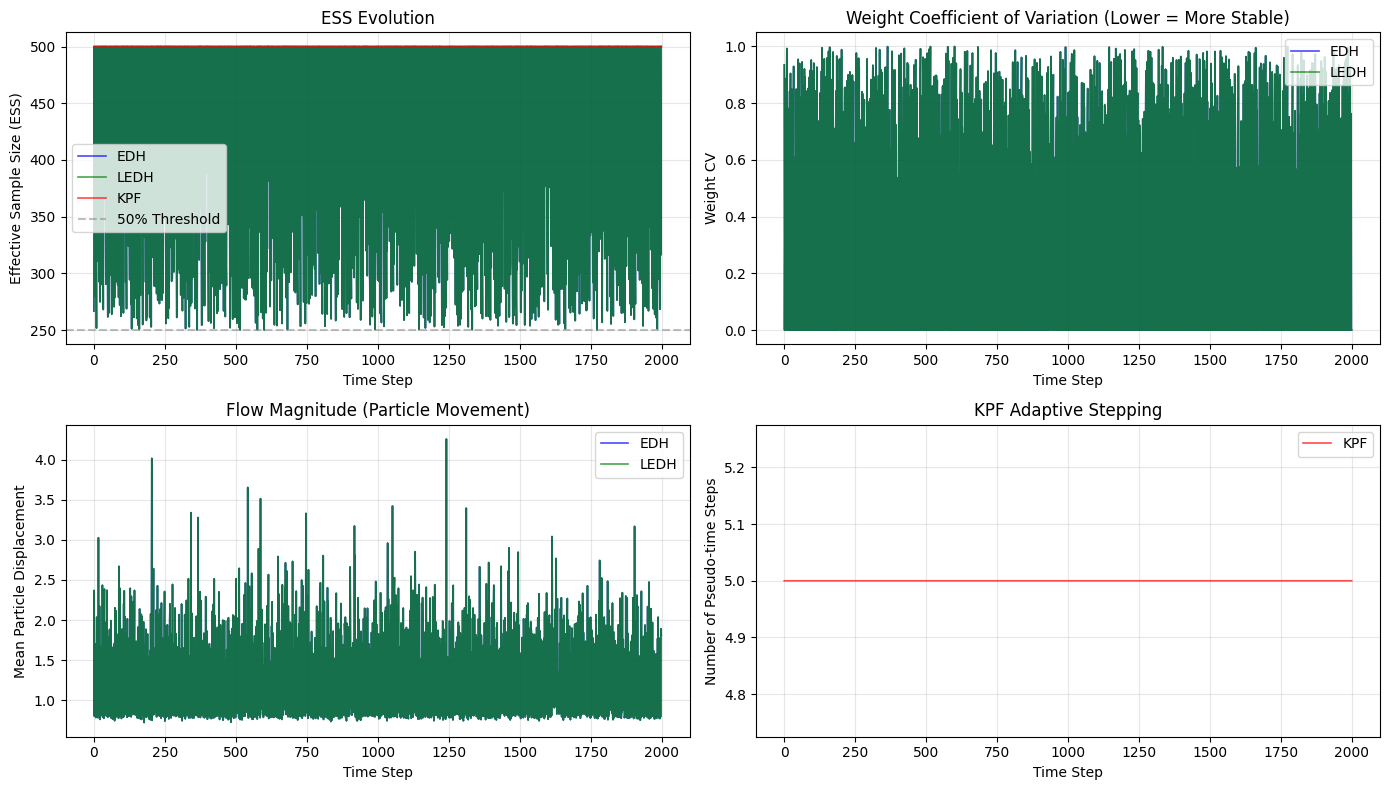

In [23]:
# Step 10: Visualization - ESS Evolution & Stability Metrics

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# ESS Evolution
ax = axes[0, 0]
for results in [edh_results, ledh_results, kpf_results]:
    color = colors[results.filter_name]
    ax.plot(time_steps, results.ess_history, color=color, linewidth=1.2, 
            label=f'{results.filter_name}', alpha=0.7)
ax.axhline(y=N_PARTICLES*0.5, color='gray', linestyle='--', alpha=0.5, label='50% Threshold')
ax.set_xlabel('Time Step')
ax.set_ylabel('Effective Sample Size (ESS)')
ax.set_title('ESS Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Weight Coefficient of Variation (stability indicator)
ax = axes[0, 1]
for results in [edh_results, ledh_results]:  # KPF has uniform weights
    if 'stability' in results.flow_diagnostics and results.flow_diagnostics['stability']:
        stability = results.flow_diagnostics['stability']
        if stability.weight_cv:
            color = colors[results.filter_name]
            ax.plot(time_steps, stability.weight_cv, color=color, linewidth=1.2, 
                    label=f'{results.filter_name}', alpha=0.7)
ax.set_xlabel('Time Step')
ax.set_ylabel('Weight CV')
ax.set_title('Weight Coefficient of Variation (Lower = More Stable)')
ax.legend()
ax.grid(True, alpha=0.3)

# Particle Displacement (flow magnitude)
ax = axes[1, 0]
for results in [edh_results, ledh_results]:
    if 'stability' in results.flow_diagnostics and results.flow_diagnostics['stability']:
        stability = results.flow_diagnostics['stability']
        if stability.particle_displacements:
            # Plot mean displacement per time step
            mean_disp = [np.mean(d) for d in stability.particle_displacements]
            color = colors[results.filter_name]
            ax.plot(time_steps, mean_disp, color=color, linewidth=1.2, 
                    label=f'{results.filter_name}', alpha=0.7)
ax.set_xlabel('Time Step')
ax.set_ylabel('Mean Particle Displacement')
ax.set_title('Flow Magnitude (Particle Movement)')
ax.legend()
ax.grid(True, alpha=0.3)

# KPF Pseudo-time Steps
ax = axes[1, 1]
if 'stability' in kpf_results.flow_diagnostics and kpf_results.flow_diagnostics['stability']:
    stability = kpf_results.flow_diagnostics['stability']
    if stability.n_steps:
        ax.plot(time_steps, stability.n_steps, color=colors['KPF'], linewidth=1.2, 
                label='KPF', alpha=0.7)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Number of Pseudo-time Steps')
        ax.set_title('KPF Adaptive Stepping')
        ax.legend()
        ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'KPF step data\nnot available', 
            ha='center', va='center', transform=ax.transAxes)
    ax.axis('off')

plt.tight_layout()
plt.show()

---

# Experiment 2: Nonlinearity Analysis

Test filter robustness to varying degrees of nonlinearity by scaling observation and process noise.

## 2.1: Observation Noise Scaling (β variation)

The observation model is: $Y_t = \beta \exp(X_t/2) \cdot w_t$, where $w_t \sim N(0,1)$.

- **Higher β** → larger observation noise → harder to correct particles
- **Lower β** → higher SNR → easier filtering

We'll test: **β ∈ {0.25, 0.5, 1.0, 2.0}** (baseline is β=0.5)

In [24]:
# Experiment 2.1: Helper function to run filters with different noise parameters

def run_noise_sensitivity_experiment(
    beta_values: List[float],
    sigma_val: float,
    alpha_val: float,
    Y_obs_original: np.ndarray,
    X_true: np.ndarray,
    n_particles: int = 500,
    n_lambda_steps: int = 10,
    seed: int = 42
) -> pd.DataFrame:
    """
    Run all three filters with varying observation noise (beta).
    
    Parameters
    ----------
    beta_values : List[float]
        Different beta (obs noise scale) values to test
    sigma_val : float
        Process noise (fixed for this experiment)
    alpha_val : float
        AR(1) coefficient (fixed)
    Y_obs_original : np.ndarray
        Original observations
    X_true : np.ndarray
        True state sequence
    n_particles : int
        Number of particles
    n_lambda_steps : int
        Lambda integration steps
    seed : int
        Random seed
    
    Returns
    -------
    pd.DataFrame
        Results table with RMSE, time, etc. for each (filter, beta) combination
    """
    results_records = []
    
    for beta_val in beta_values:
        print(f"\n{'='*80}")
        print(f"  Testing β = {beta_val:.2f} (obs noise scale)")
        print(f"{'='*80}")
        
        # Update model functions with new beta
        def log_like_pdf_beta(y, x):
            var = beta_val**2 * np.exp(x)
            return -0.5 * np.log(2 * np.pi * var) - 0.5 * (y**2 / var)
        
        # Update R matrices
        R_ukf_beta = np.array([[beta_val**2]])
        Q_ukf_beta = np.array([[sigma_val**2]])
        
        # Initialize initial state
        x0_mean_beta = np.array([0.0])
        x0_cov_beta = np.array([[sigma_val**2 / (1 - alpha_val**2)]])
        
        # --- Run EDH ---
        print(f"\n  Running EDH (β={beta_val:.2f})...")
        ukf_edh_beta = UnscentedKalmanFilter(
            g=g_sv, h=h_sv, Q=Q_ukf_beta, R=R_ukf_beta,
            alpha=ukf_alpha, beta=ukf_beta, kappa=ukf_kappa
        )
        ukf_state_edh_beta = UKFState(mean=x0_mean_beta, cov=x0_cov_beta, t=0)
        tracker_edh_beta = UKFTracker(ukf_edh_beta, ukf_state_edh_beta)
        
        edh_filter_beta = EDHFlowPF(
            tracker=tracker_edh_beta, g=g_sv, h=h_sv, jacobian_h=jacobian_h_sv,
            log_trans_pdf=log_trans_pdf_sv, log_like_pdf=log_like_pdf_beta,
            R=R_ukf_beta,
            config=EDHConfig(
                n_particles=n_particles, n_lambda_steps=n_lambda_steps,
                resample_ess_ratio=RESAMPLE_ESS_RATIO,
                flow_integrator="rk4", rng=np.random.default_rng(seed)
            )
        )
        
        edh_res = run_edh_ledh_filter(
            edh_filter_beta, "EDH", Y_obs_original, x0_mean_beta, x0_cov_beta,
            track_particles=False, track_stability=False
        )
        edh_res = finalize_results(edh_res, X_true)
        print(f"    RMSE: {edh_res.rmse:.4f}, Time: {edh_res.computation_time:.1f}s")
        
        results_records.append({
            'Beta': beta_val, 'Filter': 'EDH', 'RMSE': edh_res.rmse,
            'Bias': edh_res.bias, 'NLL': edh_res.nll,
            'Time': edh_res.computation_time, 'ESS_Mean': compute_ess_stats(edh_res.ess_history)['mean']
        })
        
        # --- Run LEDH ---
        print(f"  Running LEDH (β={beta_val:.2f})...")
        ukf_ledh_beta = UnscentedKalmanFilter(
            g=g_sv, h=h_sv, Q=Q_ukf_beta, R=R_ukf_beta,
            alpha=ukf_alpha, beta=ukf_beta, kappa=ukf_kappa
        )
        ukf_state_ledh_beta = UKFState(mean=x0_mean_beta, cov=x0_cov_beta, t=0)
        tracker_ledh_beta = UKFTracker(ukf_ledh_beta, ukf_state_ledh_beta)
        
        ledh_filter_beta = LEDHFlowPF(
            tracker=tracker_ledh_beta, g=g_sv, h=h_sv, jacobian_h=jacobian_h_sv,
            log_trans_pdf=log_trans_pdf_sv, log_like_pdf=log_like_pdf_beta,
            R=R_ukf_beta,
            config=LEDHConfig(
                n_particles=n_particles, n_lambda_steps=n_lambda_steps,
                resample_ess_ratio=RESAMPLE_ESS_RATIO,
                rng=np.random.default_rng(seed)
            )
        )
        
        ledh_res = run_edh_ledh_filter(
            ledh_filter_beta, "LEDH", Y_obs_original, x0_mean_beta, x0_cov_beta,
            track_particles=False, track_stability=False
        )
        ledh_res = finalize_results(ledh_res, X_true)
        print(f"    RMSE: {ledh_res.rmse:.4f}, Time: {ledh_res.computation_time:.1f}s")
        
        results_records.append({
            'Beta': beta_val, 'Filter': 'LEDH', 'RMSE': ledh_res.rmse,
            'Bias': ledh_res.bias, 'NLL': ledh_res.nll,
            'Time': ledh_res.computation_time, 'ESS_Mean': compute_ess_stats(ledh_res.ess_history)['mean']
        })
        
        # --- Run KPF ---
        print(f"  Running KPF (β={beta_val:.2f})...")
        kpf_model_beta = Model(H=h_sv, JH=jacobian_h_sv, R=R_ukf_beta)
        kpf_filter_beta = KernelParticleFilter(model=kpf_model_beta, config=kpf_config)
        kpf_init_beta = np.random.default_rng(seed).multivariate_normal(
            x0_mean_beta, x0_cov_beta, size=n_particles
        )
        
        kpf_res = run_kpf_filter(
            kpf_filter_beta, Y_obs_original, kpf_init_beta,
            track_particles=False, track_stability=False
        )
        kpf_res = finalize_results(kpf_res, X_true)
        print(f"    RMSE: {kpf_res.rmse:.4f}, Time: {kpf_res.computation_time:.1f}s")
        
        results_records.append({
            'Beta': beta_val, 'Filter': 'KPF', 'RMSE': kpf_res.rmse,
            'Bias': kpf_res.bias, 'NLL': kpf_res.nll,
            'Time': kpf_res.computation_time, 'ESS_Mean': compute_ess_stats(kpf_res.ess_history)['mean']
        })
    
    return pd.DataFrame(results_records)

print("✓ Noise sensitivity experiment function defined")

✓ Noise sensitivity experiment function defined


In [25]:
# Run Experiment 2.1: Observation Noise Sensitivity (β variation)

beta_test_values = [0.25, 0.5, 1.0, 2.0]

print("\n" + "="*80)
print("  EXPERIMENT 2.1: OBSERVATION NOISE SENSITIVITY")
print("  Testing β ∈ {0.25, 0.5, 1.0, 2.0}")
print("  (Lower β = higher SNR, easier filtering)")
print("="*80)

beta_sensitivity_results = run_noise_sensitivity_experiment(
    beta_values=beta_test_values,
    sigma_val=sigma,  # Use original sigma
    alpha_val=alpha,  # Use original alpha
    Y_obs_original=Y_obs,
    X_true=X_true,
    n_particles=N_PARTICLES,
    n_lambda_steps=N_LAMBDA_STEPS,
    seed=SEED
)

print("\n" + "="*80)
print("  EXPERIMENT 2.1: RESULTS")
print("="*80)
print(beta_sensitivity_results.to_string(index=False))
print("="*80)


  EXPERIMENT 2.1: OBSERVATION NOISE SENSITIVITY
  Testing β ∈ {0.25, 0.5, 1.0, 2.0}
  (Lower β = higher SNR, easier filtering)

  Testing β = 0.25 (obs noise scale)

  Running EDH (β=0.25)...
    RMSE: 1.6716, Time: 454.1s
  Running LEDH (β=0.25)...
    RMSE: 1.6716, Time: 1762.0s
  Running KPF (β=0.25)...
    RMSE: 2.4642, Time: 552.1s

  Testing β = 0.50 (obs noise scale)

  Running EDH (β=0.50)...
    RMSE: 1.1345, Time: 456.3s
  Running LEDH (β=0.50)...
    RMSE: 1.1345, Time: 1767.0s
  Running KPF (β=0.50)...
    RMSE: 2.4670, Time: 555.9s

  Testing β = 1.00 (obs noise scale)

  Running EDH (β=1.00)...
    RMSE: 1.6527, Time: 447.8s
  Running LEDH (β=1.00)...
    RMSE: 1.6527, Time: 1715.5s
  Running KPF (β=1.00)...
    RMSE: 2.4555, Time: 538.2s

  Testing β = 2.00 (obs noise scale)

  Running EDH (β=2.00)...
    RMSE: 2.6596, Time: 446.5s
  Running LEDH (β=2.00)...
    RMSE: 2.6596, Time: 1713.8s
  Running KPF (β=2.00)...
    RMSE: 2.4755, Time: 538.8s

  EXPERIMENT 2.1: RESUL

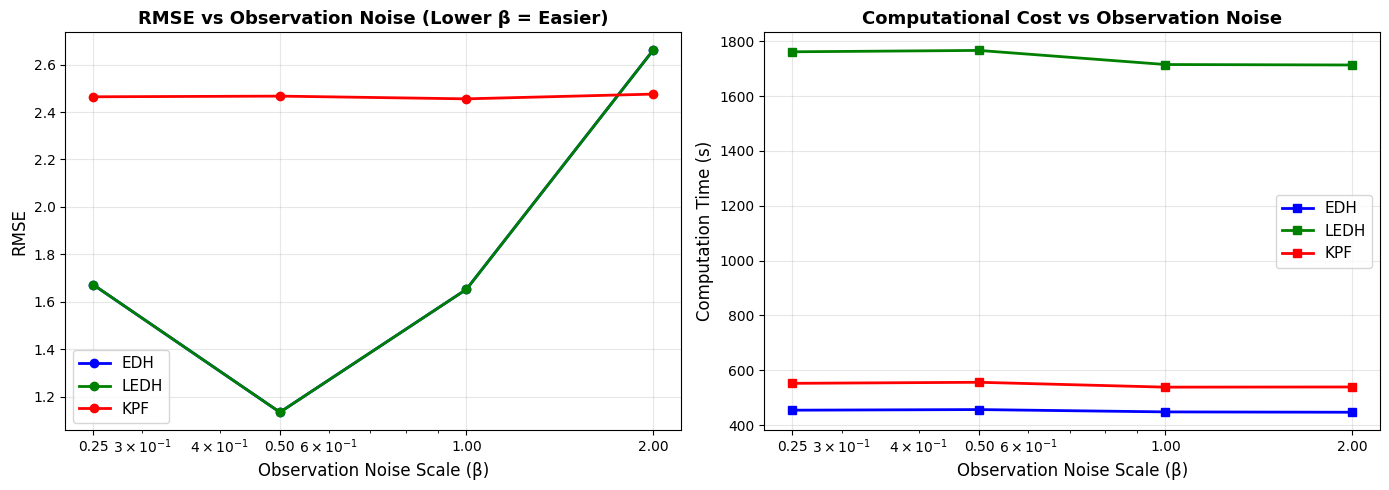


  KEY INSIGHTS: Observation Noise Sensitivity

β = 0.25:
  Best:  EDH (RMSE=1.6716)
  Worst: KPF (RMSE=2.4642)
  Ratio: 1.47x

β = 0.50:
  Best:  EDH (RMSE=1.1345)
  Worst: KPF (RMSE=2.4670)
  Ratio: 2.17x

β = 1.00:
  Best:  EDH (RMSE=1.6527)
  Worst: KPF (RMSE=2.4555)
  Ratio: 1.49x

β = 2.00:
  Best:  KPF (RMSE=2.4755)
  Worst: EDH (RMSE=2.6596)
  Ratio: 1.07x


In [26]:
# Visualization: Observation Noise Sensitivity

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE vs Beta
ax = axes[0]
for filter_name in ['EDH', 'LEDH', 'KPF']:
    filter_data = beta_sensitivity_results[beta_sensitivity_results['Filter'] == filter_name]
    ax.plot(filter_data['Beta'], filter_data['RMSE'], 
            marker='o', linewidth=2, label=filter_name, color=colors[filter_name])

ax.set_xlabel('Observation Noise Scale (β)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('RMSE vs Observation Noise (Lower β = Easier)', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.set_xticks(beta_test_values)
ax.set_xticklabels([f'{b:.2f}' for b in beta_test_values])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Computation Time vs Beta
ax = axes[1]
for filter_name in ['EDH', 'LEDH', 'KPF']:
    filter_data = beta_sensitivity_results[beta_sensitivity_results['Filter'] == filter_name]
    ax.plot(filter_data['Beta'], filter_data['Time'], 
            marker='s', linewidth=2, label=filter_name, color=colors[filter_name])

ax.set_xlabel('Observation Noise Scale (β)', fontsize=12)
ax.set_ylabel('Computation Time (s)', fontsize=12)
ax.set_title('Computational Cost vs Observation Noise', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.set_xticks(beta_test_values)
ax.set_xticklabels([f'{b:.2f}' for b in beta_test_values])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "="*80)
print("  KEY INSIGHTS: Observation Noise Sensitivity")
print("="*80)

for beta_val in beta_test_values:
    print(f"\nβ = {beta_val:.2f}:")
    beta_data = beta_sensitivity_results[beta_sensitivity_results['Beta'] == beta_val]
    best_filter = beta_data.loc[beta_data['RMSE'].idxmin(), 'Filter']
    best_rmse = beta_data['RMSE'].min()
    worst_filter = beta_data.loc[beta_data['RMSE'].idxmax(), 'Filter']
    worst_rmse = beta_data['RMSE'].max()
    print(f"  Best:  {best_filter} (RMSE={best_rmse:.4f})")
    print(f"  Worst: {worst_filter} (RMSE={worst_rmse:.4f})")
    print(f"  Ratio: {worst_rmse/best_rmse:.2f}x")

## 2.2: Process Noise Scaling (σ variation)

The process model is: $X_t = \alpha X_{t-1} + \sigma v_t$, where $v_t \sim N(0,1)$.

- **Higher σ** → more stochastic dynamics → harder state prediction
- **Lower σ** → more deterministic dynamics → easier filtering

We'll test: **σ ∈ {0.5, 1.0, 2.0}** (baseline is σ=1.0)

In [27]:
# Helper function for process noise sensitivity experiment

def run_process_noise_sensitivity_experiment(
    sigma_values: List[float],
    beta_val: float,
    alpha_val: float,
    Y_obs_original: np.ndarray,
    X_true: np.ndarray,
    n_particles: int = 500,
    n_lambda_steps: int = 10,
    seed: int = 42
) -> pd.DataFrame:
    """Run all three filters with varying process noise (sigma)."""
    results_records = []
    
    for sigma_val in sigma_values:
        print(f"\n{'='*80}")
        print(f"  Testing σ = {sigma_val:.2f} (process noise)")
        print(f"{'='*80}")
        
        # Update model functions with new sigma
        def g_sv_sigma(x, u=None, v=None):
            if v is None:
                v = 0.0
            return alpha_val * x + sigma_val * v
        
        def log_trans_pdf_sigma(x_k, x_km1):
            mean = alpha_val * x_km1
            var = sigma_val**2
            return -0.5 * np.log(2 * np.pi * var) - 0.5 * ((x_k - mean)**2 / var)
        
        # Update covariance matrices
        R_ukf_sigma = np.array([[beta_val**2]])
        Q_ukf_sigma = np.array([[sigma_val**2]])
        
        # Initial state
        x0_mean_sigma = np.array([0.0])
        x0_cov_sigma = np.array([[sigma_val**2 / (1 - alpha_val**2)]])
        
        # --- Run EDH ---
        print(f"  Running EDH (σ={sigma_val:.2f})...")
        ukf_edh_sigma = UnscentedKalmanFilter(
            g=g_sv_sigma, h=h_sv, Q=Q_ukf_sigma, R=R_ukf_sigma,
            alpha=ukf_alpha, beta=ukf_beta, kappa=ukf_kappa
        )
        ukf_state_edh_sigma = UKFState(mean=x0_mean_sigma, cov=x0_cov_sigma, t=0)
        tracker_edh_sigma = UKFTracker(ukf_edh_sigma, ukf_state_edh_sigma)
        
        edh_filter_sigma = EDHFlowPF(
            tracker=tracker_edh_sigma, g=g_sv_sigma, h=h_sv, jacobian_h=jacobian_h_sv,
            log_trans_pdf=log_trans_pdf_sigma, log_like_pdf=log_like_pdf_sv,
            R=R_ukf_sigma,
            config=EDHConfig(
                n_particles=n_particles, n_lambda_steps=n_lambda_steps,
                resample_ess_ratio=RESAMPLE_ESS_RATIO,
                flow_integrator="rk4", rng=np.random.default_rng(seed)
            )
        )
        
        edh_res = run_edh_ledh_filter(
            edh_filter_sigma, "EDH", Y_obs_original, x0_mean_sigma, x0_cov_sigma,
            track_particles=False, track_stability=False
        )
        edh_res = finalize_results(edh_res, X_true)
        print(f"    RMSE: {edh_res.rmse:.4f}, Time: {edh_res.computation_time:.1f}s")
        
        results_records.append({
            'Sigma': sigma_val, 'Filter': 'EDH', 'RMSE': edh_res.rmse,
            'Bias': edh_res.bias, 'NLL': edh_res.nll,
            'Time': edh_res.computation_time, 'ESS_Mean': compute_ess_stats(edh_res.ess_history)['mean']
        })
        
        # --- Run LEDH ---
        print(f"  Running LEDH (σ={sigma_val:.2f})...")
        ukf_ledh_sigma = UnscentedKalmanFilter(
            g=g_sv_sigma, h=h_sv, Q=Q_ukf_sigma, R=R_ukf_sigma,
            alpha=ukf_alpha, beta=ukf_beta, kappa=ukf_kappa
        )
        ukf_state_ledh_sigma = UKFState(mean=x0_mean_sigma, cov=x0_cov_sigma, t=0)
        tracker_ledh_sigma = UKFTracker(ukf_ledh_sigma, ukf_state_ledh_sigma)
        
        ledh_filter_sigma = LEDHFlowPF(
            tracker=tracker_ledh_sigma, g=g_sv_sigma, h=h_sv, jacobian_h=jacobian_h_sv,
            log_trans_pdf=log_trans_pdf_sigma, log_like_pdf=log_like_pdf_sv,
            R=R_ukf_sigma,
            config=LEDHConfig(
                n_particles=n_particles, n_lambda_steps=n_lambda_steps,
                resample_ess_ratio=RESAMPLE_ESS_RATIO,
                rng=np.random.default_rng(seed)
            )
        )
        
        ledh_res = run_edh_ledh_filter(
            ledh_filter_sigma, "LEDH", Y_obs_original, x0_mean_sigma, x0_cov_sigma,
            track_particles=False, track_stability=False
        )
        ledh_res = finalize_results(ledh_res, X_true)
        print(f"    RMSE: {ledh_res.rmse:.4f}, Time: {ledh_res.computation_time:.1f}s")
        
        results_records.append({
            'Sigma': sigma_val, 'Filter': 'LEDH', 'RMSE': ledh_res.rmse,
            'Bias': ledh_res.bias, 'NLL': ledh_res.nll,
            'Time': ledh_res.computation_time, 'ESS_Mean': compute_ess_stats(ledh_res.ess_history)['mean']
        })
        
        # --- Run KPF ---
        print(f"  Running KPF (σ={sigma_val:.2f})...")
        kpf_model_sigma = Model(H=h_sv, JH=jacobian_h_sv, R=R_ukf_sigma)
        kpf_filter_sigma = KernelParticleFilter(model=kpf_model_sigma, config=kpf_config)
        kpf_init_sigma = np.random.default_rng(seed).multivariate_normal(
            x0_mean_sigma, x0_cov_sigma, size=n_particles
        )
        
        kpf_res = run_kpf_filter(
            kpf_filter_sigma, Y_obs_original, kpf_init_sigma,
            track_particles=False, track_stability=False
        )
        kpf_res = finalize_results(kpf_res, X_true)
        print(f"    RMSE: {kpf_res.rmse:.4f}, Time: {kpf_res.computation_time:.1f}s")
        
        results_records.append({
            'Sigma': sigma_val, 'Filter': 'KPF', 'RMSE': kpf_res.rmse,
            'Bias': kpf_res.bias, 'NLL': kpf_res.nll,
            'Time': kpf_res.computation_time, 'ESS_Mean': compute_ess_stats(kpf_res.ess_history)['mean']
        })
    
    return pd.DataFrame(results_records)

print("✓ Process noise sensitivity experiment function defined")

✓ Process noise sensitivity experiment function defined


In [28]:
# Run Experiment 2.2: Process Noise Sensitivity (σ variation)

sigma_test_values = [0.5, 1.0, 2.0]

print("\n" + "="*80)
print("  EXPERIMENT 2.2: PROCESS NOISE SENSITIVITY")
print("  Testing σ ∈ {0.5, 1.0, 2.0}")
print("  (Higher σ = more stochastic, harder filtering)")
print("="*80)

sigma_sensitivity_results = run_process_noise_sensitivity_experiment(
    sigma_values=sigma_test_values,
    beta_val=beta,  # Use original beta
    alpha_val=alpha,  # Use original alpha
    Y_obs_original=Y_obs,
    X_true=X_true,
    n_particles=N_PARTICLES,
    n_lambda_steps=N_LAMBDA_STEPS,
    seed=SEED
)

print("\n" + "="*80)
print("  EXPERIMENT 2.2: RESULTS")
print("="*80)
print(sigma_sensitivity_results.to_string(index=False))
print("="*80)


  EXPERIMENT 2.2: PROCESS NOISE SENSITIVITY
  Testing σ ∈ {0.5, 1.0, 2.0}
  (Higher σ = more stochastic, harder filtering)

  Testing σ = 0.50 (process noise)
  Running EDH (σ=0.50)...
    RMSE: 1.3517, Time: 588.0s
  Running LEDH (σ=0.50)...
    RMSE: 1.3517, Time: 1729.7s
  Running KPF (σ=0.50)...
    RMSE: 2.4899, Time: 544.1s

  Testing σ = 1.00 (process noise)
  Running EDH (σ=1.00)...
    RMSE: 1.1345, Time: 447.2s
  Running LEDH (σ=1.00)...
    RMSE: 1.1345, Time: 1732.7s
  Running KPF (σ=1.00)...
    RMSE: 2.4662, Time: 539.4s

  Testing σ = 2.00 (process noise)
  Running EDH (σ=2.00)...
    RMSE: 1.3169, Time: 447.6s
  Running LEDH (σ=2.00)...
    RMSE: 1.3169, Time: 1726.9s
  Running KPF (σ=2.00)...
    RMSE: 2.4679, Time: 541.9s

  EXPERIMENT 2.2: RESULTS
 Sigma Filter     RMSE      Bias       NLL        Time   ESS_Mean
   0.5    EDH 1.351688  0.204948 35.282150  587.957445 401.185463
   0.5   LEDH 1.351688  0.204948 35.282150 1729.655282 401.185463
   0.5    KPF 2.489871 -

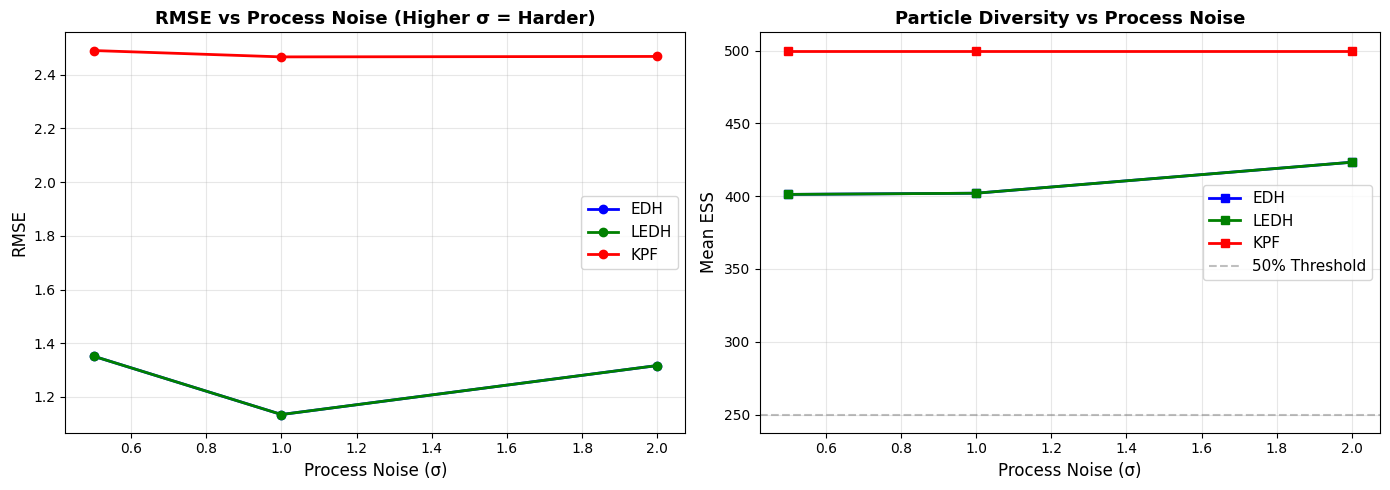


  KEY INSIGHTS: Process Noise Sensitivity

σ = 0.50:
  Best:  EDH (RMSE=1.3517)
  Worst: KPF (RMSE=2.4899)
  Ratio: 1.84x

σ = 1.00:
  Best:  EDH (RMSE=1.1345)
  Worst: KPF (RMSE=2.4662)
  Ratio: 2.17x

σ = 2.00:
  Best:  EDH (RMSE=1.3169)
  Worst: KPF (RMSE=2.4679)
  Ratio: 1.87x


In [29]:
# Visualization: Process Noise Sensitivity

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE vs Sigma
ax = axes[0]
for filter_name in ['EDH', 'LEDH', 'KPF']:
    filter_data = sigma_sensitivity_results[sigma_sensitivity_results['Filter'] == filter_name]
    ax.plot(filter_data['Sigma'], filter_data['RMSE'], 
            marker='o', linewidth=2, label=filter_name, color=colors[filter_name])

ax.set_xlabel('Process Noise (σ)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('RMSE vs Process Noise (Higher σ = Harder)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# ESS vs Sigma
ax = axes[1]
for filter_name in ['EDH', 'LEDH', 'KPF']:
    filter_data = sigma_sensitivity_results[sigma_sensitivity_results['Filter'] == filter_name]
    ax.plot(filter_data['Sigma'], filter_data['ESS_Mean'], 
            marker='s', linewidth=2, label=filter_name, color=colors[filter_name])

ax.set_xlabel('Process Noise (σ)', fontsize=12)
ax.set_ylabel('Mean ESS', fontsize=12)
ax.set_title('Particle Diversity vs Process Noise', fontsize=13, fontweight='bold')
ax.axhline(y=N_PARTICLES*0.5, color='gray', linestyle='--', alpha=0.5, label='50% Threshold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "="*80)
print("  KEY INSIGHTS: Process Noise Sensitivity")
print("="*80)

for sigma_val in sigma_test_values:
    print(f"\nσ = {sigma_val:.2f}:")
    sigma_data = sigma_sensitivity_results[sigma_sensitivity_results['Sigma'] == sigma_val]
    best_filter = sigma_data.loc[sigma_data['RMSE'].idxmin(), 'Filter']
    best_rmse = sigma_data['RMSE'].min()
    worst_filter = sigma_data.loc[sigma_data['RMSE'].idxmax(), 'Filter']
    worst_rmse = sigma_data['RMSE'].max()
    print(f"  Best:  {best_filter} (RMSE={best_rmse:.4f})")
    print(f"  Worst: {worst_filter} (RMSE={worst_rmse:.4f})")
    print(f"  Ratio: {worst_rmse/best_rmse:.2f}x")

---

# Experiment 3: Observation Sparsity

Test filter robustness when observations are missing or arrive at irregular intervals.

## Objective
Subsample observations at different intervals to simulate:
- Sensor failures
- Communication dropouts
- Cost-constrained sensing (reduce measurement frequency)

## Setup
We'll test observation intervals: **Δt ∈ {1, 2, 5, 10}**
- **Δt=1**: All observations (baseline)
- **Δt=2**: Observe every 2nd time step (50% missing)
- **Δt=5**: Observe every 5th time step (80% missing)
- **Δt=10**: Observe every 10th time step (90% missing)

In [30]:
# Helper function for observation sparsity experiment

def run_observation_sparsity_experiment(
    delta_t_values: List[int],
    Y_obs_full: np.ndarray,
    X_true_full: np.ndarray,
    n_particles: int = 500,
    n_lambda_steps: int = 10,
    seed: int = 42
) -> pd.DataFrame:
    """
    Run all three filters with varying observation sparsity.
    
    Parameters
    ----------
    delta_t_values : List[int]
        Observation intervals (1=all obs, 2=every 2nd, etc.)
    Y_obs_full : np.ndarray
        Full observation sequence
    X_true_full : np.ndarray
        Full true state sequence
    n_particles : int
        Number of particles
    n_lambda_steps : int
        Lambda integration steps
    seed : int
        Random seed
    
    Returns
    -------
    pd.DataFrame
        Results table with metrics for each (filter, Δt) combination
    """
    results_records = []
    
    for delta_t in delta_t_values:
        print(f"\n{'='*80}")
        print(f"  Testing Δt = {delta_t} (observe every {delta_t} steps)")
        print(f"  Sparsity: {100*(1-1/delta_t):.0f}% observations missing")
        print(f"{'='*80}")
        
        # Subsample observations
        obs_indices = np.arange(0, len(Y_obs_full), delta_t)
        Y_obs_sparse = Y_obs_full[obs_indices]
        X_true_sparse = X_true_full[obs_indices]
        
        print(f"  Using {len(Y_obs_sparse)} observations out of {len(Y_obs_full)} total")
        
        # Initial state
        x0_mean_sparse = np.array([0.0])
        x0_cov_sparse = np.array([[sigma**2 / (1 - alpha**2)]])
        
        # --- Run EDH ---
        print(f"\n  Running EDH (Δt={delta_t})...")
        ukf_edh_sparse = UnscentedKalmanFilter(
            g=g_sv, h=h_sv, Q=Q_ukf, R=R_ukf,
            alpha=ukf_alpha, beta=ukf_beta, kappa=ukf_kappa
        )
        ukf_state_edh_sparse = UKFState(mean=x0_mean_sparse, cov=x0_cov_sparse, t=0)
        tracker_edh_sparse = UKFTracker(ukf_edh_sparse, ukf_state_edh_sparse)
        
        edh_filter_sparse = EDHFlowPF(
            tracker=tracker_edh_sparse, g=g_sv, h=h_sv, jacobian_h=jacobian_h_sv,
            log_trans_pdf=log_trans_pdf_sv, log_like_pdf=log_like_pdf_sv,
            R=R_ukf,
            config=EDHConfig(
                n_particles=n_particles, n_lambda_steps=n_lambda_steps,
                resample_ess_ratio=RESAMPLE_ESS_RATIO,
                flow_integrator="rk4", rng=np.random.default_rng(seed)
            )
        )
        
        edh_res = run_edh_ledh_filter(
            edh_filter_sparse, "EDH", Y_obs_sparse, x0_mean_sparse, x0_cov_sparse,
            track_particles=False, track_stability=False
        )
        edh_res = finalize_results(edh_res, X_true_sparse)
        ess_stats_edh = compute_ess_stats(edh_res.ess_history)
        print(f"    RMSE: {edh_res.rmse:.4f}, Time: {edh_res.computation_time:.1f}s, ESS_min: {ess_stats_edh['min']:.1f}")
        
        results_records.append({
            'Delta_t': delta_t, 'Sparsity_%': 100*(1-1/delta_t), 'Filter': 'EDH',
            'RMSE': edh_res.rmse, 'Bias': edh_res.bias, 'NLL': edh_res.nll,
            'Time': edh_res.computation_time, 'ESS_Mean': ess_stats_edh['mean'],
            'ESS_Min': ess_stats_edh['min'], 'Resamples': edh_res.n_resamples
        })
        
        # --- Run LEDH ---
        print(f"  Running LEDH (Δt={delta_t})...")
        ukf_ledh_sparse = UnscentedKalmanFilter(
            g=g_sv, h=h_sv, Q=Q_ukf, R=R_ukf,
            alpha=ukf_alpha, beta=ukf_beta, kappa=ukf_kappa
        )
        ukf_state_ledh_sparse = UKFState(mean=x0_mean_sparse, cov=x0_cov_sparse, t=0)
        tracker_ledh_sparse = UKFTracker(ukf_ledh_sparse, ukf_state_ledh_sparse)
        
        ledh_filter_sparse = LEDHFlowPF(
            tracker=tracker_ledh_sparse, g=g_sv, h=h_sv, jacobian_h=jacobian_h_sv,
            log_trans_pdf=log_trans_pdf_sv, log_like_pdf=log_like_pdf_sv,
            R=R_ukf,
            config=LEDHConfig(
                n_particles=n_particles, n_lambda_steps=n_lambda_steps,
                resample_ess_ratio=RESAMPLE_ESS_RATIO,
                rng=np.random.default_rng(seed)
            )
        )
        
        ledh_res = run_edh_ledh_filter(
            ledh_filter_sparse, "LEDH", Y_obs_sparse, x0_mean_sparse, x0_cov_sparse,
            track_particles=False, track_stability=False
        )
        ledh_res = finalize_results(ledh_res, X_true_sparse)
        ess_stats_ledh = compute_ess_stats(ledh_res.ess_history)
        print(f"    RMSE: {ledh_res.rmse:.4f}, Time: {ledh_res.computation_time:.1f}s, ESS_min: {ess_stats_ledh['min']:.1f}")
        
        results_records.append({
            'Delta_t': delta_t, 'Sparsity_%': 100*(1-1/delta_t), 'Filter': 'LEDH',
            'RMSE': ledh_res.rmse, 'Bias': ledh_res.bias, 'NLL': ledh_res.nll,
            'Time': ledh_res.computation_time, 'ESS_Mean': ess_stats_ledh['mean'],
            'ESS_Min': ess_stats_ledh['min'], 'Resamples': ledh_res.n_resamples
        })
        
        # --- Run KPF ---
        print(f"  Running KPF (Δt={delta_t})...")
        kpf_model_sparse = Model(H=h_sv, JH=jacobian_h_sv, R=R_ukf)
        kpf_filter_sparse = KernelParticleFilter(model=kpf_model_sparse, config=kpf_config)
        kpf_init_sparse = np.random.default_rng(seed).multivariate_normal(
            x0_mean_sparse, x0_cov_sparse, size=n_particles
        )
        
        kpf_res = run_kpf_filter(
            kpf_filter_sparse, Y_obs_sparse, kpf_init_sparse,
            track_particles=False, track_stability=False
        )
        kpf_res = finalize_results(kpf_res, X_true_sparse)
        ess_stats_kpf = compute_ess_stats(kpf_res.ess_history)
        print(f"    RMSE: {kpf_res.rmse:.4f}, Time: {kpf_res.computation_time:.1f}s")
        
        results_records.append({
            'Delta_t': delta_t, 'Sparsity_%': 100*(1-1/delta_t), 'Filter': 'KPF',
            'RMSE': kpf_res.rmse, 'Bias': kpf_res.bias, 'NLL': kpf_res.nll,
            'Time': kpf_res.computation_time, 'ESS_Mean': ess_stats_kpf['mean'],
            'ESS_Min': ess_stats_kpf['min'], 'Resamples': kpf_res.n_resamples
        })
    
    return pd.DataFrame(results_records)

print("✓ Observation sparsity experiment function defined")

✓ Observation sparsity experiment function defined


In [31]:
# Run Experiment 3: Observation Sparsity

delta_t_test_values = [1, 2, 5, 10]

print("\n" + "="*80)
print("  EXPERIMENT 3: OBSERVATION SPARSITY")
print("  Testing Δt ∈ {1, 2, 5, 10}")
print("  (Higher Δt = more missing observations)")
print("="*80)

sparsity_results = run_observation_sparsity_experiment(
    delta_t_values=delta_t_test_values,
    Y_obs_full=Y_obs,
    X_true_full=X_true,
    n_particles=N_PARTICLES,
    n_lambda_steps=N_LAMBDA_STEPS,
    seed=SEED
)

print("\n" + "="*80)
print("  EXPERIMENT 3: RESULTS")
print("="*80)
print(sparsity_results.to_string(index=False))
print("="*80)


  EXPERIMENT 3: OBSERVATION SPARSITY
  Testing Δt ∈ {1, 2, 5, 10}
  (Higher Δt = more missing observations)

  Testing Δt = 1 (observe every 1 steps)
  Sparsity: 0% observations missing
  Using 2000 observations out of 2000 total

  Running EDH (Δt=1)...
    RMSE: 1.1345, Time: 448.2s, ESS_min: 250.0
  Running LEDH (Δt=1)...
    RMSE: 1.1345, Time: 1747.2s, ESS_min: 250.0
  Running KPF (Δt=1)...
    RMSE: 2.4689, Time: 541.9s

  Testing Δt = 2 (observe every 2 steps)
  Sparsity: 50% observations missing
  Using 1000 observations out of 2000 total

  Running EDH (Δt=2)...
    RMSE: 1.3534, Time: 220.5s, ESS_min: 250.3
  Running LEDH (Δt=2)...
    RMSE: 1.3534, Time: 856.0s, ESS_min: 250.3
  Running KPF (Δt=2)...
    RMSE: 2.4546, Time: 269.0s

  Testing Δt = 5 (observe every 5 steps)
  Sparsity: 80% observations missing
  Using 400 observations out of 2000 total

  Running EDH (Δt=5)...
    RMSE: 1.6483, Time: 88.1s, ESS_min: 250.3
  Running LEDH (Δt=5)...
    RMSE: 1.6483, Time: 341.6

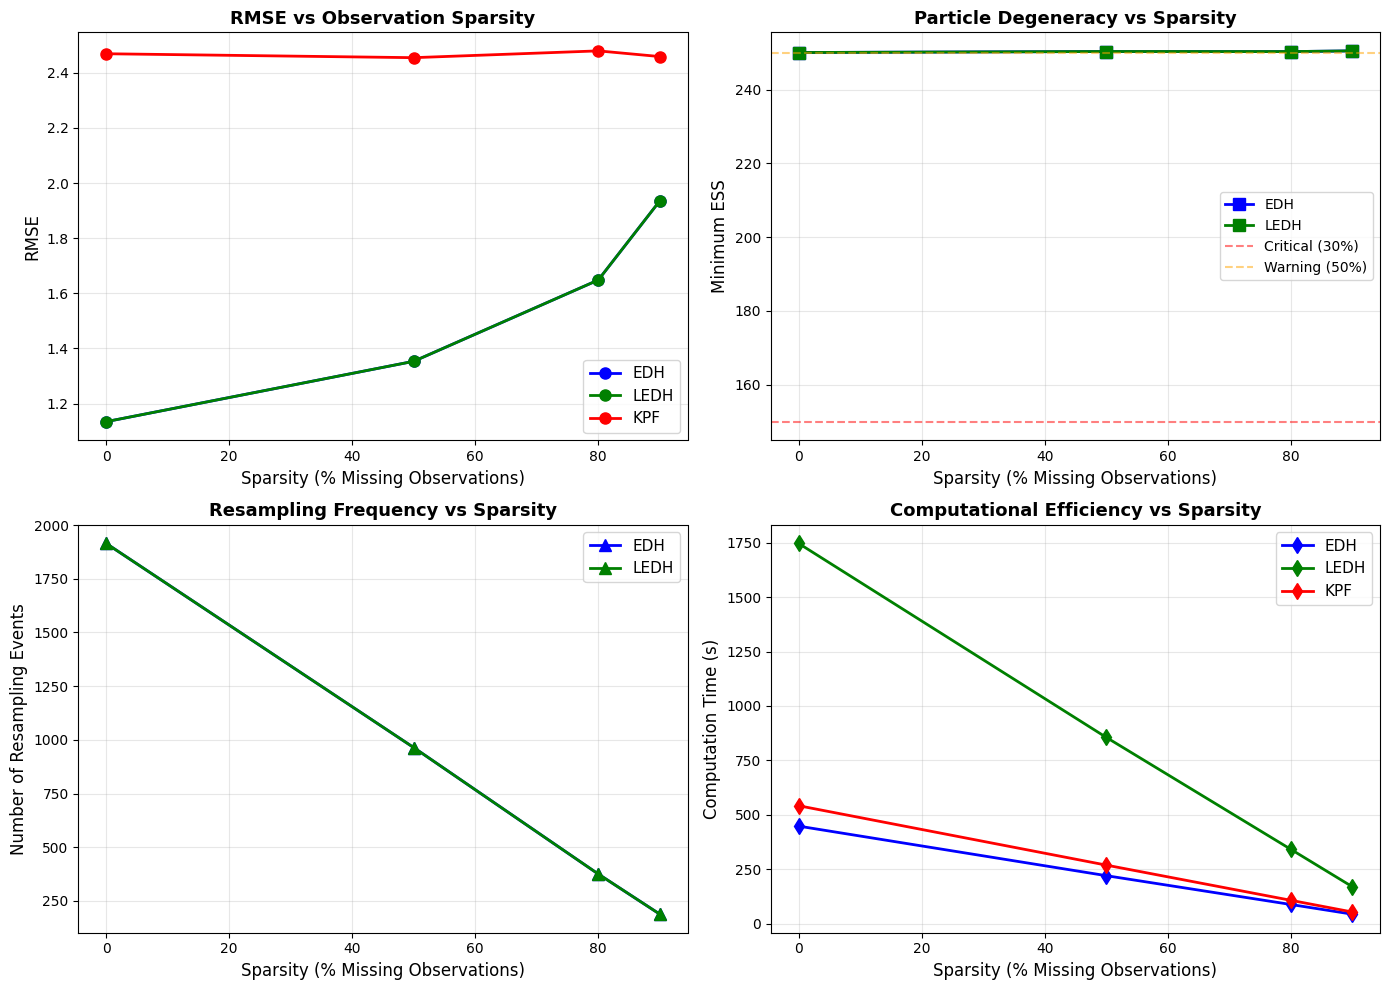


  KEY INSIGHTS: Observation Sparsity

Δt=1 (0% missing):
  Best:  EDH (RMSE=1.1345)
  Worst: KPF (RMSE=2.4689)
  Ratio: 2.18x

Δt=2 (50% missing):
  Best:  EDH (RMSE=1.3534)
  Worst: KPF (RMSE=2.4546)
  Ratio: 1.81x

Δt=5 (80% missing):
  Best:  EDH (RMSE=1.6483)
  Worst: KPF (RMSE=2.4793)
  Ratio: 1.50x

Δt=10 (90% missing):
  Best:  EDH (RMSE=1.9353)
  Worst: KPF (RMSE=2.4586)
  Ratio: 1.27x


In [32]:
# Visualization: Observation Sparsity Analysis

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE vs Sparsity
ax = axes[0, 0]
for filter_name in ['EDH', 'LEDH', 'KPF']:
    filter_data = sparsity_results[sparsity_results['Filter'] == filter_name]
    ax.plot(filter_data['Sparsity_%'], filter_data['RMSE'], 
            marker='o', linewidth=2, markersize=8, label=filter_name, color=colors[filter_name])

ax.set_xlabel('Sparsity (% Missing Observations)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('RMSE vs Observation Sparsity', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# ESS Min vs Sparsity (particle degeneracy indicator)
ax = axes[0, 1]
for filter_name in ['EDH', 'LEDH']:  # KPF doesn't resample
    filter_data = sparsity_results[sparsity_results['Filter'] == filter_name]
    ax.plot(filter_data['Sparsity_%'], filter_data['ESS_Min'], 
            marker='s', linewidth=2, markersize=8, label=filter_name, color=colors[filter_name])

ax.axhline(y=N_PARTICLES*0.3, color='red', linestyle='--', alpha=0.5, label='Critical (30%)')
ax.axhline(y=N_PARTICLES*0.5, color='orange', linestyle='--', alpha=0.5, label='Warning (50%)')
ax.set_xlabel('Sparsity (% Missing Observations)', fontsize=12)
ax.set_ylabel('Minimum ESS', fontsize=12)
ax.set_title('Particle Degeneracy vs Sparsity', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Number of Resamples vs Sparsity
ax = axes[1, 0]
for filter_name in ['EDH', 'LEDH']:
    filter_data = sparsity_results[sparsity_results['Filter'] == filter_name]
    ax.plot(filter_data['Sparsity_%'], filter_data['Resamples'], 
            marker='^', linewidth=2, markersize=8, label=filter_name, color=colors[filter_name])

ax.set_xlabel('Sparsity (% Missing Observations)', fontsize=12)
ax.set_ylabel('Number of Resampling Events', fontsize=12)
ax.set_title('Resampling Frequency vs Sparsity', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Computation Time vs Sparsity
ax = axes[1, 1]
for filter_name in ['EDH', 'LEDH', 'KPF']:
    filter_data = sparsity_results[sparsity_results['Filter'] == filter_name]
    ax.plot(filter_data['Sparsity_%'], filter_data['Time'], 
            marker='d', linewidth=2, markersize=8, label=filter_name, color=colors[filter_name])

ax.set_xlabel('Sparsity (% Missing Observations)', fontsize=12)
ax.set_ylabel('Computation Time (s)', fontsize=12)
ax.set_title('Computational Efficiency vs Sparsity', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "="*80)
print("  KEY INSIGHTS: Observation Sparsity")
print("="*80)

for delta_t in delta_t_test_values:
    sparsity_pct = 100*(1-1/delta_t)
    print(f"\nΔt={delta_t} ({sparsity_pct:.0f}% missing):")
    dt_data = sparsity_results[sparsity_results['Delta_t'] == delta_t]
    best_filter = dt_data.loc[dt_data['RMSE'].idxmin(), 'Filter']
    best_rmse = dt_data['RMSE'].min()
    worst_filter = dt_data.loc[dt_data['RMSE'].idxmax(), 'Filter']
    worst_rmse = dt_data['RMSE'].max()
    
    print(f"  Best:  {best_filter} (RMSE={best_rmse:.4f})")
    print(f"  Worst: {worst_filter} (RMSE={worst_rmse:.4f})")
    print(f"  Ratio: {worst_rmse/best_rmse:.2f}x")
    
    # Check for degeneracy
    for filt in ['EDH', 'LEDH']:
        filt_data = dt_data[dt_data['Filter'] == filt].iloc[0]
        ess_min = filt_data['ESS_Min']
        if ess_min < N_PARTICLES * 0.3:
            print(f"  ⚠️  {filt}: SEVERE degeneracy (ESS_min={ess_min:.1f})")
        elif ess_min < N_PARTICLES * 0.5:
            print(f"  ⚡ {filt}: Moderate degeneracy (ESS_min={ess_min:.1f})")

---

# Experiment 4: Stability Diagnostics Deep-Dive

## Objective
Perform detailed analysis of numerical stability and flow dynamics for each filter by monitoring:
- **Flow magnitude**: Particle displacement during pseudo-time integration
- **Jacobian conditioning**: Determinant of flow Jacobian (θ) for EDH/LEDH
- **Matrix conditioning**: Condition number of innovation covariance S(λ)
- **Weight stability**: Coefficient of variation and degeneracy patterns

In [19]:
# Setup for Experiment 4: Stability Diagnostics

# Re-import time module (in case it was overwritten)
import time as time_module
import time

STABILITY_TEST_LENGTH = 500  # Shorter sequence for detailed analysis
STABILITY_BETA = 1.0  # Higher observation noise
STABILITY_SIGMA = sigma  # Keep same process noise

# Subsample observations for stability test
Y_stability = Y_obs[:STABILITY_TEST_LENGTH]
X_stability = X_true[:STABILITY_TEST_LENGTH]
time_steps_stab = np.arange(STABILITY_TEST_LENGTH)

print("="*80)
print("  EXPERIMENT 4: STABILITY DIAGNOSTICS SETUP")
print("="*80)
print(f"  Test length: {STABILITY_TEST_LENGTH} steps")
print(f"  Observation noise (β): {STABILITY_BETA}")
print(f"  Process noise (σ): {STABILITY_SIGMA}")
print("="*80)

  EXPERIMENT 4: STABILITY DIAGNOSTICS SETUP
  Test length: 500 steps
  Observation noise (β): 1.0
  Process noise (σ): 1.0


In [25]:
# Compute RMSE for the results
edh_results_enhanced.rmse = np.sqrt(np.mean((edh_results_enhanced.X_est - X_stability)**2))
ledh_results_enhanced.rmse = np.sqrt(np.mean((ledh_results_enhanced.X_est - X_stability)**2))
kpf_results_enhanced.rmse = np.sqrt(np.mean((kpf_results_enhanced.X_est - X_stability)**2))

print("✓ RMSE computed:")
print(f"  EDH:  {edh_results_enhanced.rmse:.4f}")
print(f"  LEDH: {ledh_results_enhanced.rmse:.4f}")
print(f"  KPF:  {kpf_results_enhanced.rmse:.4f}")

✓ RMSE computed:
  EDH:  1.1422
  LEDH: 1.1422
  KPF:  2.1516


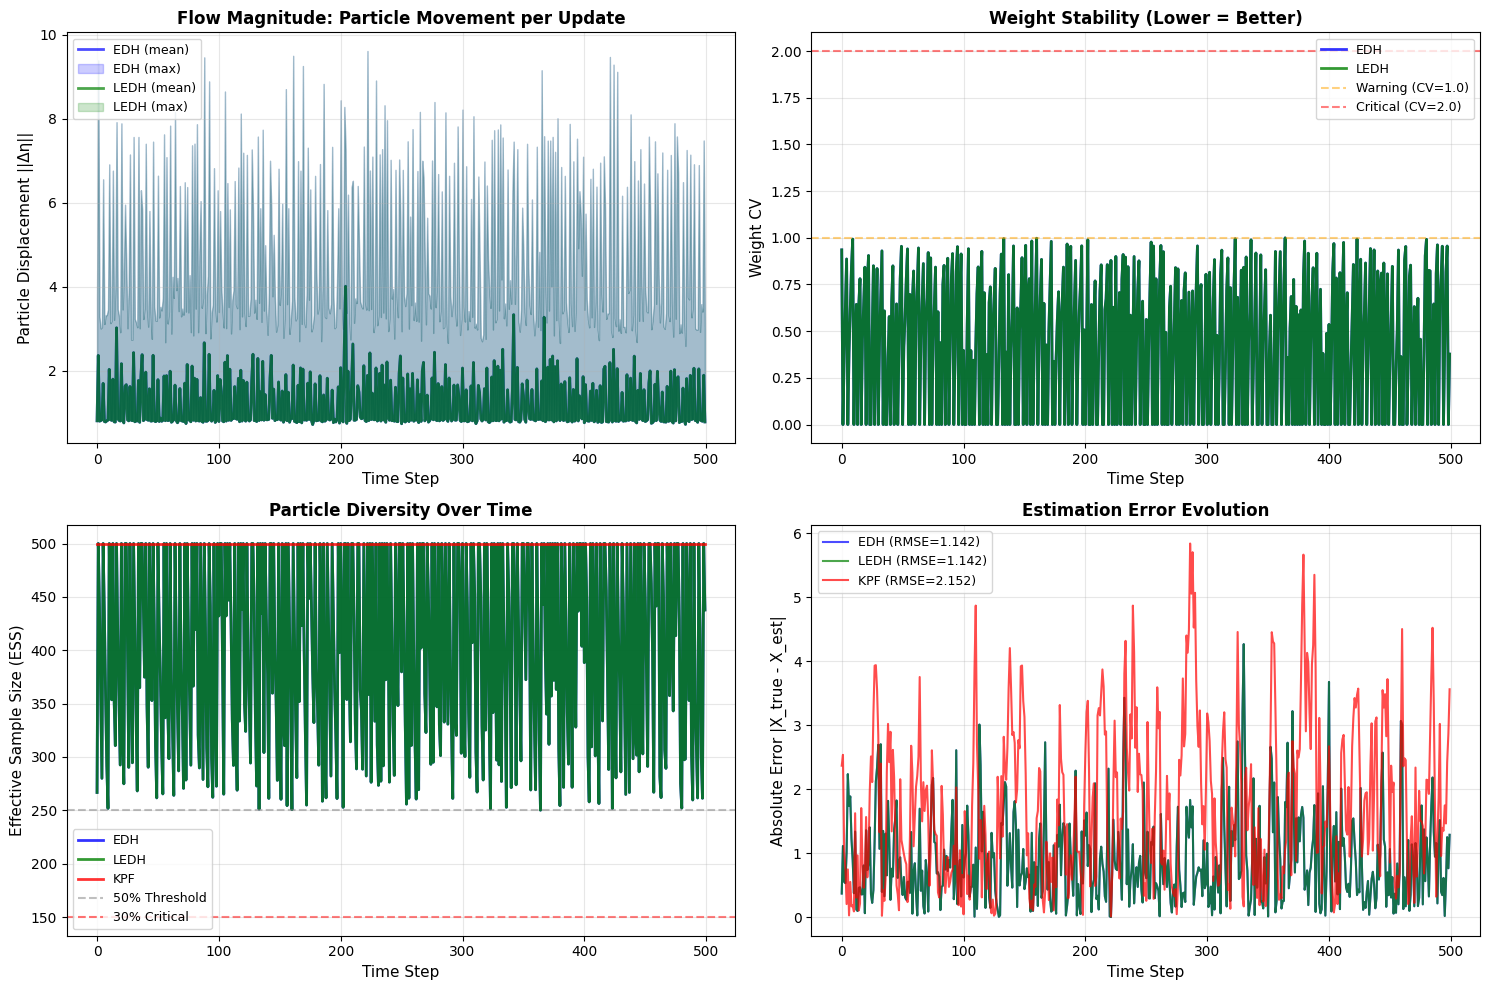

In [27]:
# Stability Visualization 1: Flow Magnitude Analysis

# Define colors for consistent plotting
colors = {'EDH': 'blue', 'LEDH': 'green', 'KPF': 'red'}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
time_steps_stab = np.arange(STABILITY_TEST_LENGTH)

# Panel 1: Particle Displacement (Flow Magnitude)
ax = axes[0, 0]
for results, name in [(edh_results_enhanced, 'EDH'), (ledh_results_enhanced, 'LEDH')]:
    if 'stability' in results.flow_diagnostics and results.flow_diagnostics['stability']:
        stability = results.flow_diagnostics['stability']
        if stability.particle_displacements:
            # Compute mean and max displacement per timestep
            mean_disp = [np.mean(d) for d in stability.particle_displacements]
            max_disp = [np.max(d) for d in stability.particle_displacements]
            
            ax.plot(time_steps_stab, mean_disp, linewidth=2, label=f'{name} (mean)', 
                   color=colors[name], alpha=0.7)
            ax.fill_between(time_steps_stab, mean_disp, max_disp, 
                           color=colors[name], alpha=0.2, label=f'{name} (max)')

ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('Particle Displacement ||Δη||', fontsize=11)
ax.set_title('Flow Magnitude: Particle Movement per Update', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 2: Weight Coefficient of Variation (stability indicator)
ax = axes[0, 1]
for results, name in [(edh_results_enhanced, 'EDH'), (ledh_results_enhanced, 'LEDH')]:
    if 'stability' in results.flow_diagnostics and results.flow_diagnostics['stability']:
        stability = results.flow_diagnostics['stability']
        if stability.weight_cv:
            ax.plot(time_steps_stab, stability.weight_cv, linewidth=2, 
                   label=name, color=colors[name], alpha=0.8)

ax.axhline(y=1.0, color='orange', linestyle='--', alpha=0.5, label='Warning (CV=1.0)')
ax.axhline(y=2.0, color='red', linestyle='--', alpha=0.5, label='Critical (CV=2.0)')
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('Weight CV', fontsize=11)
ax.set_title('Weight Stability (Lower = Better)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 3: ESS Evolution with Resampling Events
ax = axes[1, 0]
for results, name in [(edh_results_enhanced, 'EDH'), (ledh_results_enhanced, 'LEDH'), (kpf_results_enhanced, 'KPF')]:
    ax.plot(time_steps_stab, results.ess_history, linewidth=2, 
           label=name, color=colors[name], alpha=0.8)

ax.axhline(y=N_PARTICLES*0.5, color='gray', linestyle='--', alpha=0.5, label='50% Threshold')
ax.axhline(y=N_PARTICLES*0.3, color='red', linestyle='--', alpha=0.5, label='30% Critical')
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('Effective Sample Size (ESS)', fontsize=11)
ax.set_title('Particle Diversity Over Time', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Panel 4: Estimation Error vs Time
ax = axes[1, 1]
for results, name in [(edh_results_enhanced, 'EDH'), (ledh_results_enhanced, 'LEDH'), (kpf_results_enhanced, 'KPF')]:
    abs_error = np.abs(X_stability - results.X_est)
    ax.plot(time_steps_stab, abs_error, linewidth=1.5, 
           label=f'{name} (RMSE={results.rmse:.3f})', color=colors[name], alpha=0.7)

ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('Absolute Error |X_true - X_est|', fontsize=11)
ax.set_title('Estimation Error Evolution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

⚠️  Particle Cloud Visualization Skipped
Particle histories were not tracked during filter execution.
To enable this visualization, rerun the filters with track_particles=True

Showing alternative: State estimate comparison at selected timepoints



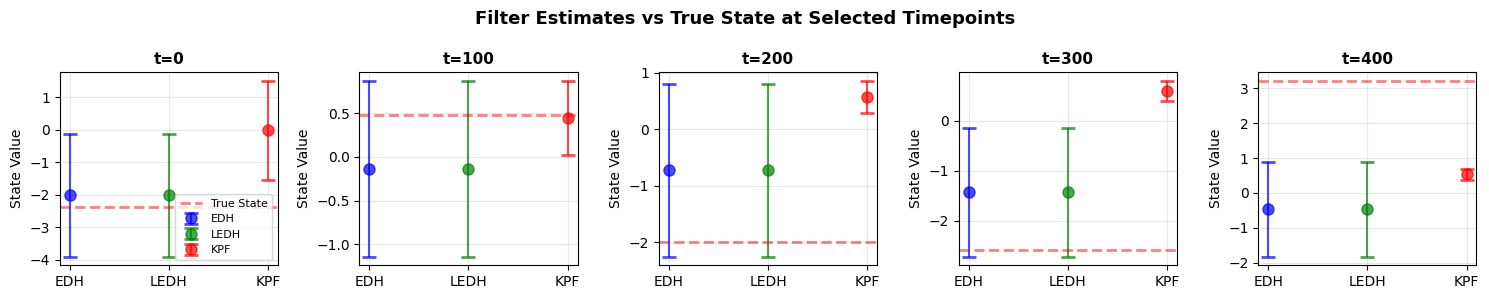

In [28]:
# Stability Visualization 2: Particle Cloud Evolution

# Check if particle histories are available
if (not edh_results_enhanced.particles_history and 
    not ledh_results_enhanced.particles_history and 
    not kpf_results_enhanced.particles_history):
    print("⚠️  Particle Cloud Visualization Skipped")
    print("="*80)
    print("Particle histories were not tracked during filter execution.")
    print("To enable this visualization, rerun the filters with track_particles=True")
    print("="*80)
    print("\nShowing alternative: State estimate comparison at selected timepoints")
    print()
    
    # Alternative visualization: Show estimate vs true state at snapshots
    snapshot_times = [0, 100, 200, 300, 400]
    snapshot_times = [t for t in snapshot_times if t < STABILITY_TEST_LENGTH]
    
    fig, axes = plt.subplots(1, len(snapshot_times), figsize=(15, 3))
    
    for idx, t in enumerate(snapshot_times):
        ax = axes[idx] if len(snapshot_times) > 1 else axes
        
        # Plot true state and estimates
        filters_data = [
            ('EDH', edh_results_enhanced.X_est[t], edh_results_enhanced.X_std[t], 'blue'),
            ('LEDH', ledh_results_enhanced.X_est[t], ledh_results_enhanced.X_std[t], 'green'),
            ('KPF', kpf_results_enhanced.X_est[t], kpf_results_enhanced.X_std[t], 'red')
        ]
        
        positions = [0, 1, 2]
        for pos, (name, est, std, color) in zip(positions, filters_data):
            ax.errorbar(pos, est, yerr=std, fmt='o', color=color, 
                       capsize=5, capthick=2, markersize=8, label=name, alpha=0.7)
        
        # True state line
        ax.axhline(y=X_stability[t], color='red', linestyle='--', 
                  linewidth=2, alpha=0.5, label='True State')
        
        ax.set_title(f't={t}', fontsize=11, fontweight='bold')
        ax.set_xticks(positions)
        ax.set_xticklabels(['EDH', 'LEDH', 'KPF'])
        ax.set_ylabel('State Value', fontsize=10)
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.legend(fontsize=8, loc='best')
    
    plt.suptitle('Filter Estimates vs True State at Selected Timepoints', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
else:
    # Original particle cloud visualization (if particles were tracked)
    snapshot_times = [0, 100, 200, 300, 400]
    snapshot_times = [t for t in snapshot_times if t < STABILITY_TEST_LENGTH]
    
    fig, axes = plt.subplots(len(snapshot_times), 3, figsize=(15, 3*len(snapshot_times)))
    
    for idx, t in enumerate(snapshot_times):
        # EDH particles
        ax = axes[idx, 0] if len(snapshot_times) > 1 else axes[0]
        if edh_results_enhanced.particles_history:
            particles = edh_results_enhanced.particles_history[t]
            weights = edh_results_enhanced.weights_history[t]
            
            ax.hist(particles[:, 0], bins=30, weights=weights, 
                   alpha=0.6, color=colors['EDH'], edgecolor='black', linewidth=0.5)
            ax.axvline(X_stability[t], color='red', linestyle='--', linewidth=2, label='True State')
            ax.axvline(edh_results_enhanced.X_est[t], color='blue', linestyle='-', linewidth=2, label='Estimate')
            ax.set_title(f'EDH at t={t}' if idx == 0 else f't={t}', fontsize=11)
            ax.set_xlabel('State Value', fontsize=10)
            ax.set_ylabel('Weighted Density', fontsize=10)
            if idx == 0:
                ax.legend(fontsize=9)
        
        # LEDH particles
        ax = axes[idx, 1] if len(snapshot_times) > 1 else axes[1]
        if ledh_results_enhanced.particles_history:
            particles = ledh_results_enhanced.particles_history[t]
            weights = ledh_results_enhanced.weights_history[t]
            
            ax.hist(particles[:, 0], bins=30, weights=weights, 
                   alpha=0.6, color=colors['LEDH'], edgecolor='black', linewidth=0.5)
            ax.axvline(X_stability[t], color='red', linestyle='--', linewidth=2, label='True State')
            ax.axvline(ledh_results_enhanced.X_est[t], color='green', linestyle='-', linewidth=2, label='Estimate')
            ax.set_title(f'LEDH at t={t}' if idx == 0 else f't={t}', fontsize=11)
            ax.set_xlabel('State Value', fontsize=10)
            if idx == 0:
                ax.legend(fontsize=9)
        
        # KPF particles
        ax = axes[idx, 2] if len(snapshot_times) > 1 else axes[2]
        if kpf_results_enhanced.particles_history:
            particles = kpf_results_enhanced.particles_history[t]
            
            ax.hist(particles[:, 0], bins=30, alpha=0.6, 
                   color=colors['KPF'], edgecolor='black', linewidth=0.5)
            ax.axvline(X_stability[t], color='red', linestyle='--', linewidth=2, label='True State')
            ax.axvline(kpf_results_enhanced.X_est[t], color='darkred', linestyle='-', linewidth=2, label='Estimate')
            ax.set_title(f'KPF at t={t}' if idx == 0 else f't={t}', fontsize=11)
            ax.set_xlabel('State Value', fontsize=10)
            if idx == 0:
                ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

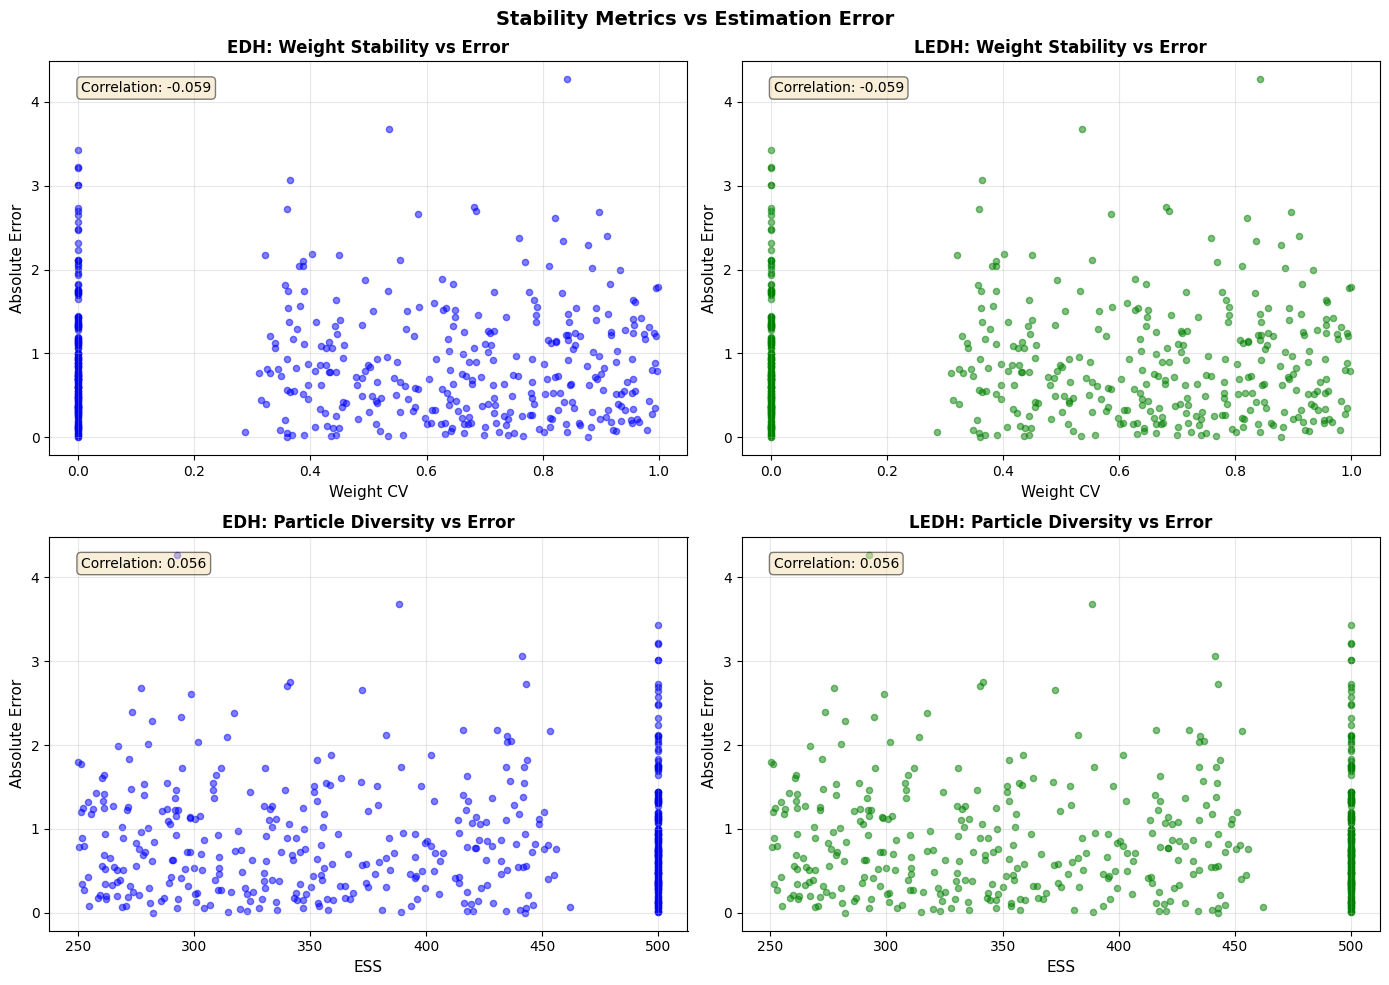


  CORRELATION ANALYSIS

Positive correlation → Higher metric value = Higher error (BAD)
Negative correlation → Higher metric value = Lower error (GOOD)


In [23]:
# Stability Visualization 3: Correlation Analysis

# Analyze correlation between stability metrics and estimation error

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# EDH: Weight CV vs Error
ax = axes[0, 0]
if 'stability' in edh_results_enhanced.flow_diagnostics and edh_results_enhanced.flow_diagnostics['stability']:
    stability = edh_results_enhanced.flow_diagnostics['stability']
    if stability.weight_cv:
        abs_error_edh = np.abs(X_stability - edh_results_enhanced.X_est)
        ax.scatter(stability.weight_cv, abs_error_edh, alpha=0.5, s=20, color=colors['EDH'])
        ax.set_xlabel('Weight CV', fontsize=11)
        ax.set_ylabel('Absolute Error', fontsize=11)
        ax.set_title('EDH: Weight Stability vs Error', fontsize=12, fontweight='bold')
        
        # Compute correlation
        corr = np.corrcoef(stability.weight_cv, abs_error_edh)[0, 1]
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
               transform=ax.transAxes, fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.grid(True, alpha=0.3)

# LEDH: Weight CV vs Error
ax = axes[0, 1]
if 'stability' in ledh_results_enhanced.flow_diagnostics and ledh_results_enhanced.flow_diagnostics['stability']:
    stability = ledh_results_enhanced.flow_diagnostics['stability']
    if stability.weight_cv:
        abs_error_ledh = np.abs(X_stability - ledh_results_enhanced.X_est)
        ax.scatter(stability.weight_cv, abs_error_ledh, alpha=0.5, s=20, color=colors['LEDH'])
        ax.set_xlabel('Weight CV', fontsize=11)
        ax.set_ylabel('Absolute Error', fontsize=11)
        ax.set_title('LEDH: Weight Stability vs Error', fontsize=12, fontweight='bold')
        
        corr = np.corrcoef(stability.weight_cv, abs_error_ledh)[0, 1]
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
               transform=ax.transAxes, fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax.grid(True, alpha=0.3)

# EDH: ESS vs Error
ax = axes[1, 0]
abs_error_edh = np.abs(X_stability - edh_results_enhanced.X_est)
ax.scatter(edh_results_enhanced.ess_history, abs_error_edh, alpha=0.5, s=20, color=colors['EDH'])
ax.set_xlabel('ESS', fontsize=11)
ax.set_ylabel('Absolute Error', fontsize=11)
ax.set_title('EDH: Particle Diversity vs Error', fontsize=12, fontweight='bold')
corr = np.corrcoef(edh_results_enhanced.ess_history, abs_error_edh)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
       transform=ax.transAxes, fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.grid(True, alpha=0.3)

# LEDH: ESS vs Error
ax = axes[1, 1]
abs_error_ledh = np.abs(X_stability - ledh_results_enhanced.X_est)
ax.scatter(ledh_results_enhanced.ess_history, abs_error_ledh, alpha=0.5, s=20, color=colors['LEDH'])
ax.set_xlabel('ESS', fontsize=11)
ax.set_ylabel('Absolute Error', fontsize=11)
ax.set_title('LEDH: Particle Diversity vs Error', fontsize=12, fontweight='bold')
corr = np.corrcoef(ledh_results_enhanced.ess_history, abs_error_ledh)[0, 1]
ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
       transform=ax.transAxes, fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.grid(True, alpha=0.3)

plt.suptitle('Stability Metrics vs Estimation Error', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("  CORRELATION ANALYSIS")
print("="*80)
print("\nPositive correlation → Higher metric value = Higher error (BAD)")
print("Negative correlation → Higher metric value = Lower error (GOOD)")
print("="*80)